In [24]:
from pandas import Timedelta, to_datetime
from matplotlib.pyplot import subplots, savefig, show, legend, close
from pandas import read_csv, read_parquet
from glob import glob
from collections import defaultdict
from pandas import Series
from tqdm.auto import tqdm
from plotly.subplots import make_subplots
from plotly.graph_objects import Figure, Scatter
from random import choice as choose_randomly
from pandas import Timestamp
from pandas.core.indexes.base import Index
from tqdm.notebook import tqdm
from pandas import DataFrame, IndexSlice
from gc import collect as garbage_collect

subset_data: bool = False

def make_biometrics_plots_together_matplotlib(
    data: defaultdict[str, defaultdict[str, defaultdict[str, Series]]],
    user_id: str,
    session_id: str,
    dataset: str,
    experiment_info: DataFrame,
    **kwargs
) -> None:
    data = {key: val for key, val in data.items() if val is not None}
    fig, axs = subplots(len(data.keys()), 1, figsize=(14, 11 * len(data.keys())), sharex=True)
    if len(data.keys()) == 1:
        axs = [axs]

    for n, (data_type, physiological_data) in tqdm(
        enumerate(data.items()), desc="Plotting data", total=len(data.keys())
    ):
        if physiological_data is None:
            continue
        
        for side, specific_side_data in physiological_data.items():
            user_data: DataFrame = specific_side_data[user_id]

            if data_type == "EDA":
                eda_type: str = kwargs["eda_type"]
                data_to_plot = user_data[eda_type]
            else:
                data_to_plot = user_data.iloc[:, 0]

            data_to_plot = data_to_plot.loc[IndexSlice[session_id, :]]
            if subset_data: 
                data_to_plot = data_to_plot[:1000]

            data_to_plot.index = to_datetime(data_to_plot.index)
            axs[n].plot(
                data_to_plot.index,
                data_to_plot.values,
                label=side,
                linestyle='-',
            )
            axs[n].set_title(data_type)

            # del data_to_plot
            # garbage_collect()

        # session_id_corrected: Timestamp = to_datetime(
        #     session_ids["left"].split("-")[0], format="%y%m%d"
        # )  + Timedelta("1D")
        # session_id_corrected: str = str(session_id_corrected.date())
        if dataset == 'mwc2022':
            start_exp = Timestamp(
                experiment_info.loc[
                    IndexSlice[user_id, session_id], "actual_bed_time"
                ]
            )
            end_exp = Timestamp(
                experiment_info.loc[
                    IndexSlice[user_id, session_id], "wake_up_time"
                ]
            )
            # start_exp = start_exp.tz_localize("Europe/Rome")
            # end_exp = end_exp.tz_localize("Europe/Rome")

            
            axs[n].axvspan(xmin=start_exp, 
                            xmax=end_exp, 
                            color='#828282', 
                            alpha=0.3, 
                            label='sleep time')
            axs[n].set_ylabel(f'Time')
            axs[n].set_ylabel(f'{data_type}')
        elif dataset == "usi_laughs":
            events = set(["_".join(col.split("_")[1:]) for col in experiment_info.columns])
            for i, event in enumerate(events):
                start_exp = Timestamp(
                experiment_info.loc[
                    user_id, f"start_{event}"
                ]
            )
                end_exp = Timestamp(
                    experiment_info.loc[
                        user_id, f"end_{event}"
                    ]
                )
                if "baseline" in event and i == 0:
                    label = "baseline"
                elif "baseline" not in event:
                    label = event
                else:
                    label = None
                
                axs[n].axvspan(xmin=start_exp, 
                                xmax=end_exp, 
                                color='#828282' if "baseline" in event else "#548572", 
                                alpha=0.3, 
                                label=label)
                axs[n].set_ylabel(f'Time')
                axs[n].set_ylabel(f'{data_type}')
        else:
            raise ValueError(f'Received as dataset {dataset}, but only mwc2022 and usi_laughs are supported')

    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(handles, 
               labels, 
               fontsize='x-large', 
               title='Side', 
               title_fontsize='xx-large', 
            #    loc='best'
               )
    # legend()
    fig.suptitle(f'Plots for all singals for user {user_id}, session {session_id}', fontsize=30, y=0.97)
    savefig(f'../visualizations/{dataset}_{user_id}_{session_id}.pdf')
    # show()
    close()
    
    return start_exp, end_exp

# Intro

This notebook is intended to provide data exploration for all datasets concerning this Lateralization study. As the moment, the datasets impemented are:
* USILaughs
* MWC2022 study

More should follow

# MWC 2022

## Sleep Info

For the moment, I shall consider the self-reports for the sleep data.

In [2]:
from pandas import read_csv, to_datetime

In [3]:
experiment_info = read_csv('../data.nosync/mwc2022/all_experimento_info.csv', index_col=[0,1])
experiment_info['actual_bed_time'] = experiment_info['actual_bed_time'].apply(to_datetime)
experiment_info['wake_up_time'] = experiment_info['wake_up_time'].apply(to_datetime)
experiment_info['actual_bed_time'] = experiment_info['actual_bed_time'].dt.tz_localize('Europe/Rome')
experiment_info['wake_up_time'] = experiment_info['wake_up_time'].dt.tz_localize('Europe/Rome')

At the moment, I am excluding sessions with weird bed and wake up times, since they do not make sense.

In [4]:
experiment_info

index             bed_time latency  \
participant_id Date                                             
U09            2022-11-20    239  2022-11-20 01:45:00      15   
               2022-11-18    235  2022-11-18 00:15:00      15   
               2022-11-27    253  2022-11-27 03:05:00      10   
               2022-11-29    257  2022-11-29 23:42:00      30   
               2022-11-28    255  2022-11-28 00:33:00      21   
...                          ...                  ...     ...   
U10            2022-12-16    340  2022-12-16 00:30:59     5.0   
               2022-11-30    148  2022-11-30 00:28:00      10   
               2022-12-17    341  2022-12-17 00:40:58     5.0   
               2022-12-19    343  2022-12-19 00:32:54     3.0   
               2022-12-21    345  2022-12-21 03:00:17     0.0   

                                       wake_up_time awakening  \
participant_id Date                                             
U09            2022-11-20 2022-11-20 08:45:00+01:00         1   
               2022-11-18 2022-11-18 07:38:00+01:00         2   
               2022-11-27 2022-11-27 09:43:00+01:00         0   
               2022-11-29 2022-11-29 07:45:00+01:00         0   
               2022-11-28 2022-11-28 08:08:00+01:00         0   
...                                             ...       ...   
U10            2022-12-16 2022-12-16 08:18:13+01:00       3.0   
               2022-11-30 2022-11-30 07:06:00+01:00         2   
               2022-12-17 2022-12-17 08:20:10+01:00       0.0   
               2022-12-19 2022-12-19 06:40:08+01:00       0.0   
               2022-12-21 2022-12-21 07:34:36+01:00       0.0   

                          awakening_duration  \
participant_id Date                            
U09            2022-11-20                  2   
               2022-11-18                  2   
               2022-11-27                  0   
               2022-11-29                  0   
               2022-11-28                  0   
...                                      ...   
U10            2022-12-16           00:15:00   
               2022-11-30                NaN   
               2022-12-17           00:00:00   
               2022-12-19           00:00:00   
               2022-12-21           00:00:00   

                                                         disturbance_reasons  \
participant_id Date                                                            
U09            2022-11-20                                                NaN   
               2022-11-18                                feeling too hot (2)   
               2022-11-27                                                NaN   
               2022-11-29                                                NaN   
               2022-11-28                                                NaN   
...                                                                      ...   
U10            2022-12-16  My cat wanted to get outside so I had to open ...   
               2022-11-30                                                NaN   
               2022-12-17                                                  -   
               2022-12-19                                                  -   
               2022-12-21                                                  -   

                           recovery  sleep_quality morning_comments  \
participant_id Date                                                   
U09            2022-11-20       6.0            6.0              NaN   
               2022-11-18       7.0            8.0              NaN   
               2022-11-27       6.0            6.0              NaN   
               2022-11-29       6.0            6.0              NaN   
               2022-11-28       7.0            7.0              NaN   
...                             ...            ...              ...   
U10            2022-12-16       6.0            4.0                -   
               2022-11-30     

In [5]:
experiment_info = experiment_info[~weird_times_mask]

NameError: name 'weird_times_mask' is not defined

In [6]:
experiment_info.sort_index()

index             bed_time latency  \
participant_id Date                                             
U01            2022-11-22    163  2022-11-22 01:46:00      15   
               2022-11-23    165  2022-11-23 02:00:00       5   
               2022-11-24    167  2022-11-24 01:00:00      10   
               2022-11-25    169  2022-11-25 00:30:00      10   
               2022-11-26    171  2022-11-26 23:30:00      10   
...                          ...                  ...     ...   
U13            2022-12-19     44  2022-12-19 23:07:51    10.0   
               2022-12-20     45  2022-12-20 23:30:37    10.0   
               2022-12-21     46  2022-12-21 03:12:22    10.0   
               2022-12-22     47  2022-12-22 23:05:00     4.0   
               2022-12-23     48  2022-12-23 23:18:18     3.0   

                                       wake_up_time awakening  \
participant_id Date                                             
U01            2022-11-22 2022-11-22 07:30:00+01:00         3   
               2022-11-23 2022-11-23 07:00:00+01:00         2   
               2022-11-24 2022-11-24 07:30:00+01:00         3   
               2022-11-25 2022-11-25 05:15:00+01:00         3   
               2022-11-26 2022-11-26 07:00:00+01:00         3   
...                                             ...       ...   
U13            2022-12-19 2022-12-19 07:38:01+01:00       3.0   
               2022-12-20 2022-12-20 07:40:47+01:00       2.0   
               2022-12-21 2022-12-21 06:48:31+01:00       1.0   
               2022-12-22 2022-12-22 08:02:07+01:00       1.0   
               2022-12-23 2022-12-23 08:04:28+01:00       0.0   

                          awakening_duration  \
participant_id Date                            
U01            2022-11-22                 15   
               2022-11-23                NaN   
               2022-11-24                NaN   
               2022-11-25                NaN   
               2022-11-26                NaN   
...                                      ...   
U13            2022-12-19           00:47:00   
               2022-12-20           00:25:00   
               2022-12-21           00:16:00   
               2022-12-22           00:09:00   
               2022-12-23           00:00:00   

                                                         disturbance_reasons  \
participant_id Date                                                            
U01            2022-11-22                                                NaN   
               2022-11-23                                                NaN   
               2022-11-24                                                NaN   
               2022-11-25                                                NaN   
               2022-11-26                                feeling too hot (1)   
...                                                                      ...   
U13            2022-12-19                       Could not sleep for headache   
               2022-12-20                                   Not feeling well   
               2022-12-21  Worked before going to sleep. Very cold in the...   
               2022-12-22                                               Nope   
               2022-12-23                                               Nope   

                           recovery  sleep_quality          morning_comments  \
participant_id Date                                                            
U01            2022-11-22       6.0            4.0                       NaN   
               2022-11-23       3.0            6.0                       NaN   
               2022-11-24       7.0            6.0                       NaN   
               2022-11-25       3.0            4.0                       NaN   
               2022-11-26       9.0            6.0  slept in a different bed   
...                             ...            ...                       ...   
U13            2022-12-19    

## Physiological Data

In [7]:
from pandas import read_csv, read_parquet
from glob import glob
from collections import defaultdict
from pandas import Series
from tqdm.auto import tqdm
from plotly.subplots import make_subplots
from plotly.graph_objects import Figure, Scatter
from random import choice as choose_randomly
from pandas import Timestamp
from pandas.core.indexes.base import Index
from tqdm.notebook import tqdm
from pandas import DataFrame, IndexSlice
from gc import collect as garbage_collect

In [8]:
eda_data_base_path: str = "../data.nosync/mwc2022/filtered/*/EDA/*.parquet"
eda_data_paths: list[str] = glob(eda_data_base_path)

In [9]:
eda_data: defaultdict[str, defaultdict[str, Series]] = defaultdict(lambda: defaultdict())
for file in tqdm(eda_data_paths, desc='Loading EDA data'):
    side_name = file.split("/")[-3]
    user_name = file.split("/")[-1].split(".")[0]
    eda_data[side_name][user_name] = read_parquet(file)

Loading EDA data:   0%|          | 0/19 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [9]:
bvp_data_base_path: str = "../data.nosync/mwc2022/filtered/*/BVP/*.parquet"
bvp_data_paths: list[str] = glob(bvp_data_base_path)
bvp_data = None

In [10]:
bvp_data: defaultdict[str, defaultdict[str, Series]] = defaultdict(lambda: defaultdict())
for file in tqdm(bvp_data_paths, desc='Loading BVP data'):
    side_name = file.split("/")[-3]
    user_name = file.split("/")[-1].split(".")[0]
    bvp_data[side_name][user_name] = read_parquet(file)

Loading BVP data:   0%|          | 0/19 [00:00<?, ?it/s]

In [10]:
physiological_data: dict[str, defaultdict[str, defaultdict[str, Series]]] = {
    "EDA": eda_data,
    "BVP": bvp_data,
}
del eda_data
del bvp_data
garbage_collect()

329

In [11]:
physiological_data['EDA']['right']['U13']

mixed-EDA  phasic-EDA
session    timestamp                                              
2022-11-17 2022-11-17 00:29:38+01:00         -0.356251   -0.179237
           2022-11-17 00:29:38.250000+01:00  -0.333540   -0.179237
           2022-11-17 00:29:38.500000+01:00  -0.311632   -0.131899
           2022-11-17 00:29:38.750000+01:00  -0.295311   -0.090009
           2022-11-17 00:29:39+01:00         -0.284433   -0.067429
...                                                ...         ...
2022-12-22 2022-12-22 08:10:29.750000+01:00  -0.717994    3.498308
           2022-12-22 08:10:30+01:00         -0.727297    3.469839
           2022-12-22 08:10:30.250000+01:00  -0.732028    3.448389
           2022-12-22 08:10:30.500000+01:00  -0.736577    3.433078
           2022-12-22 08:10:30.750000+01:00  -0.740937    3.343001

[4410792 rows x 2 columns]

In [41]:
# from pandas import Timedelta, to_datetime


# def make_biometrics_plots_together_plotly(
#     data: defaultdict[str, defaultdict[str, defaultdict[str, Series]]],
#     user_id: str,
#     session_ids: dict[str, str],
#     experiment_info: DataFrame,
#     **kwargs
# ) -> None:
#     fig = make_subplots(rows=len(data.keys()), cols=1, shared_xaxes=True)

#     for n, (data_type, physiological_data) in tqdm(
#         enumerate(data.items()), desc="Plotting data", total=len(data.keys())
#     ):
#         for side, specific_side_data in physiological_data.items():
#             user_data: DataFrame = specific_side_data[user_id]

#             if data_type == "EDA":
#                 eda_type: str = kwargs["eda_type"]
#                 data_to_plot = user_data[eda_type]
#             else:
#                 data_to_plot = user_data.iloc[:, 0]

#             data_to_plot = data_to_plot.loc[IndexSlice[session_ids[side], :]]

#             fig.add_trace(
#                 Scatter(
#                     x=data_to_plot.index,
#                     y=data_to_plot.values,
#                     mode="lines",
#                     name=side,
#                 ),
#                 row=n + 1,
#                 col=1,
#             )

#             # del data_to_plot
#             # garbage_collect()

#         session_id_corrected: Timestamp = to_datetime(session_ids["left"].split("-")[0], format='%y%m%d') + Timedelta(
#             "1D"
#         )
#         session_id_corrected: str = str(session_id_corrected.date())
#         start_exp = Timestamp(
#             experiment_info.loc[
#                 IndexSlice[user_id, session_id_corrected], "actual_bed_time"
#             ]
#         )
#         end_exp = Timestamp(
#             experiment_info.loc[
#                 IndexSlice[user_id, session_id_corrected], "wake_up_time"
#             ]
#         )
#         start_exp = start_exp.tz_localize("Europe/Rome")
#         end_exp = end_exp.tz_localize("Europe/Rome")

#         fig.add_vrect(
#             x0=start_exp,
#             x1=end_exp,
#             fillcolor="#828282",
#             opacity=0.3,
#             line_width=0,
#             name="experiment time",
#             row=n + 1,
#             col=1,
#         )

#     fig.update_layout(autosize=False, width=800, height=1600)
#     fig.show()


# user_id = "U13"
# session_ids = {"left": "221129-221810", "right": "221129-221752"}

# make_biometrics_plots_together(
#     data=physiological_data,
#     user_id=user_id,
#     session_ids=session_ids,
#     experiment_info=experiment_info,
#     eda_type="phasic-EDA",
# )


In [12]:


import ipywidgets as widgets

users_left = physiological_data["EDA"]["left"].keys()
users_right = physiological_data["EDA"]["right"].keys()
users = list(set(users_left) & set(users_right))

user_selection = widgets.Dropdown(
    options=sorted(users),
    value=users[0],
    description='User:',
    disabled=False,
)
display(user_selection)

Dropdown(description='User:', index=1, options=('U01', 'U02', 'U03', 'U04', 'U06', 'U09', 'U10', 'U13'), value…

In [43]:
user = user_selection.value

sessions_right = physiological_data["EDA"]["left"][user].index.get_level_values(0).unique()
sessions_left = physiological_data["EDA"]["right"][user].index.get_level_values(0).unique()
sessions = list(set(sessions_right) & set(sessions_left))
    
if user not in experiment_info.index.get_level_values(0).unique():
    print(f'{user} not in experiment info. Skipping')
morning_survey_sessions = experiment_info.loc[IndexSlice[user, :], :].index.get_level_values(1).unique()


sessions_all = list(set(sessions) & set(morning_survey_sessions))
if len(sessions_all) == 0:
    raise ValueError(f'No sessions for user {user} found')
session_selection = widgets.Dropdown(
    options=sorted(sessions_all),
    value=sessions_all[0],
    description='Session:',
    disabled=False,)
display(session_selection)

Dropdown(description='Session:', index=10, options=('2022-11-17', '2022-11-18', '2022-11-19', '2022-11-20', '2…

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

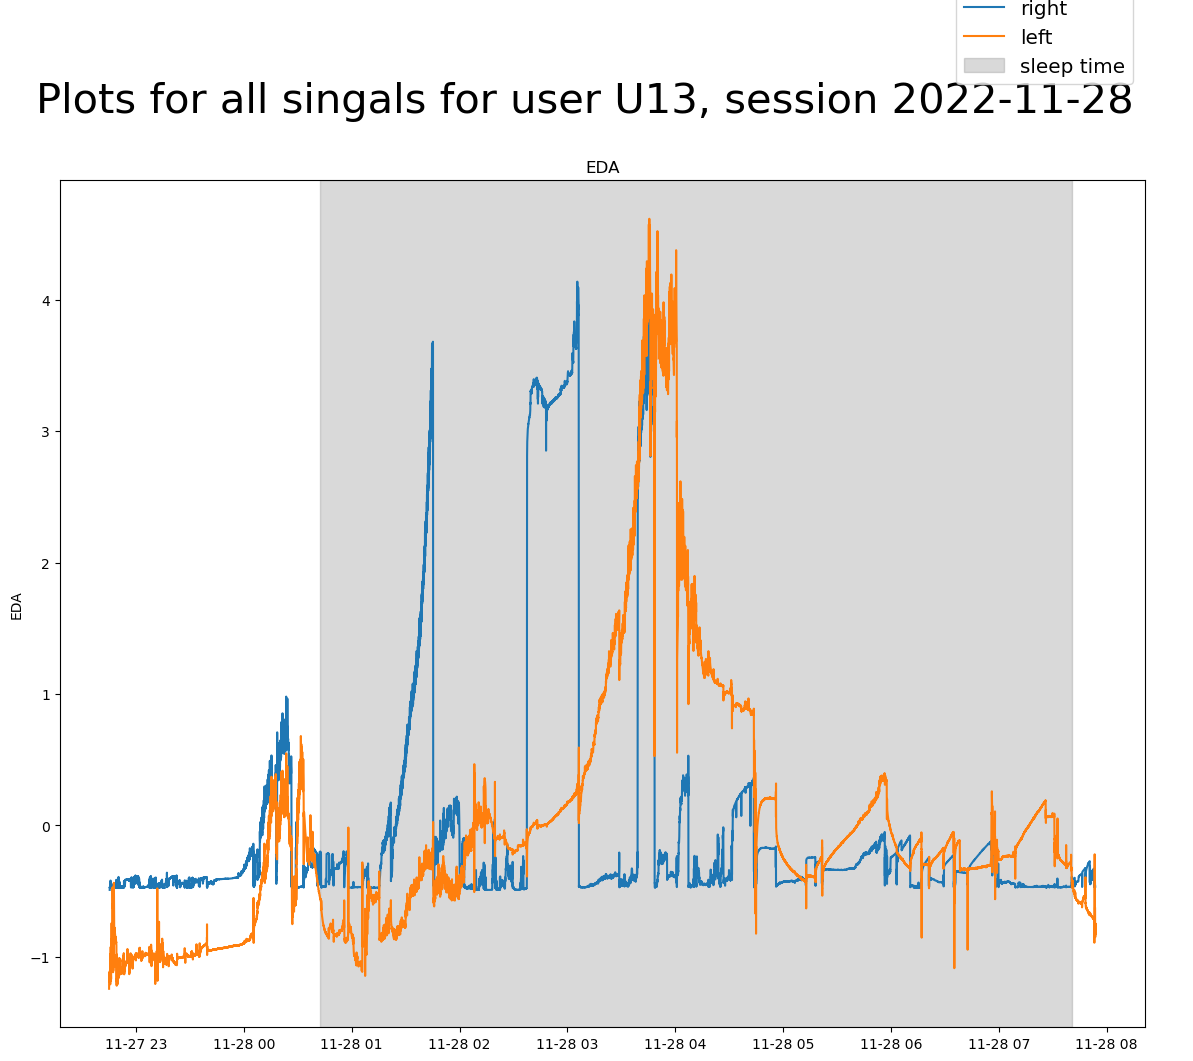

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

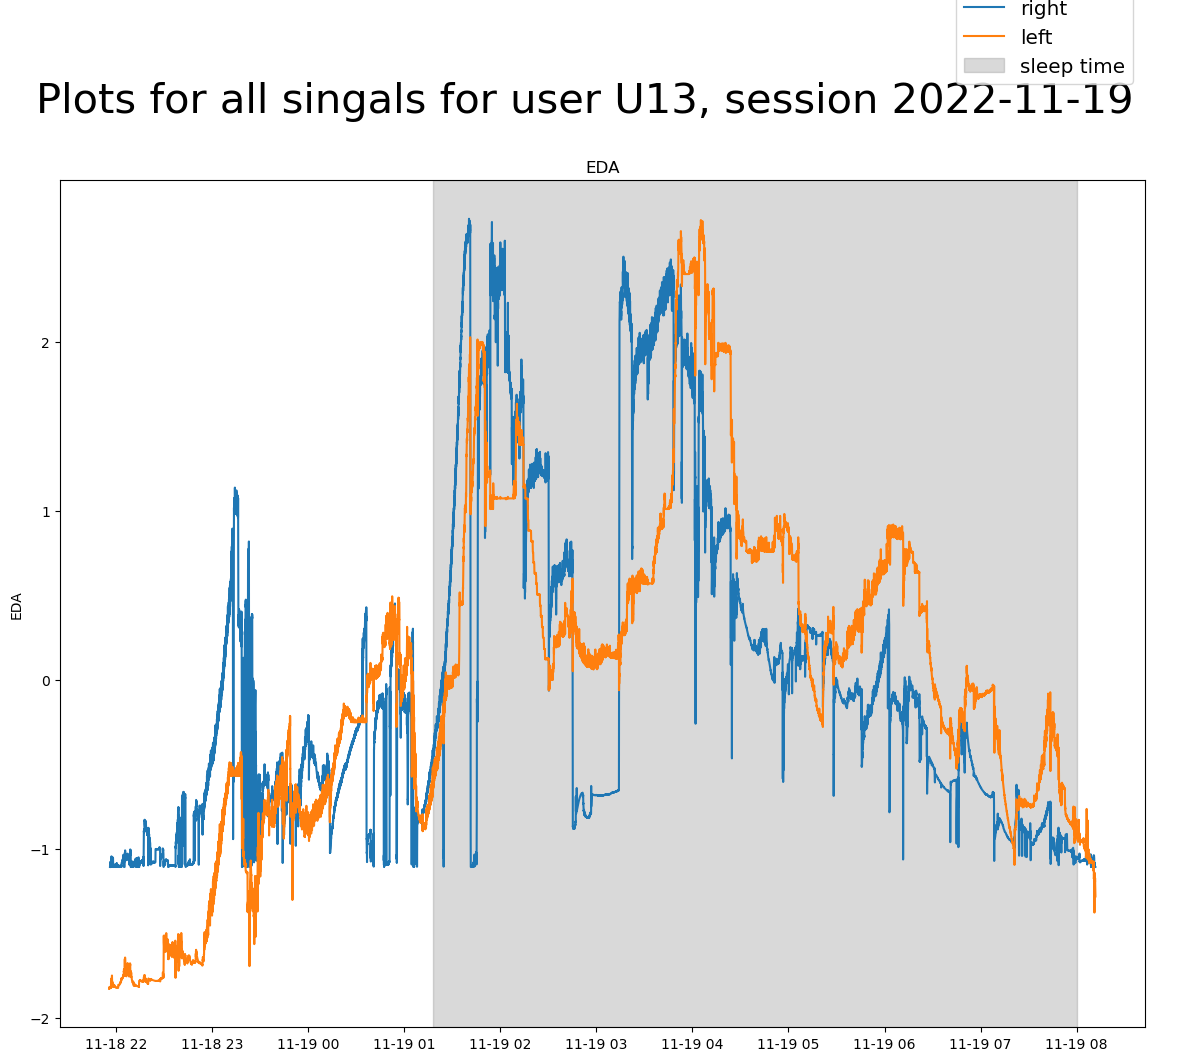

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

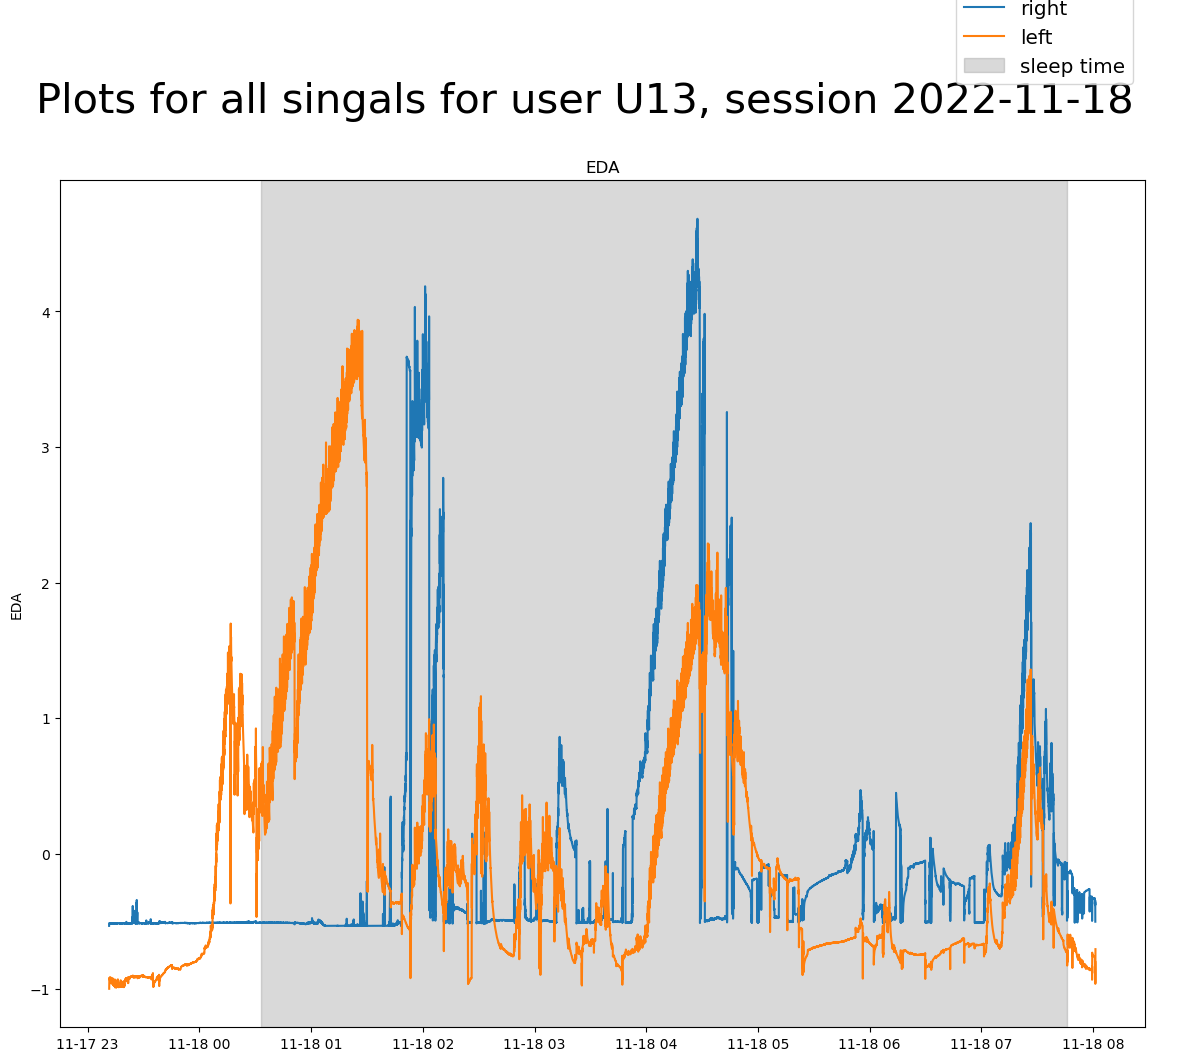

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

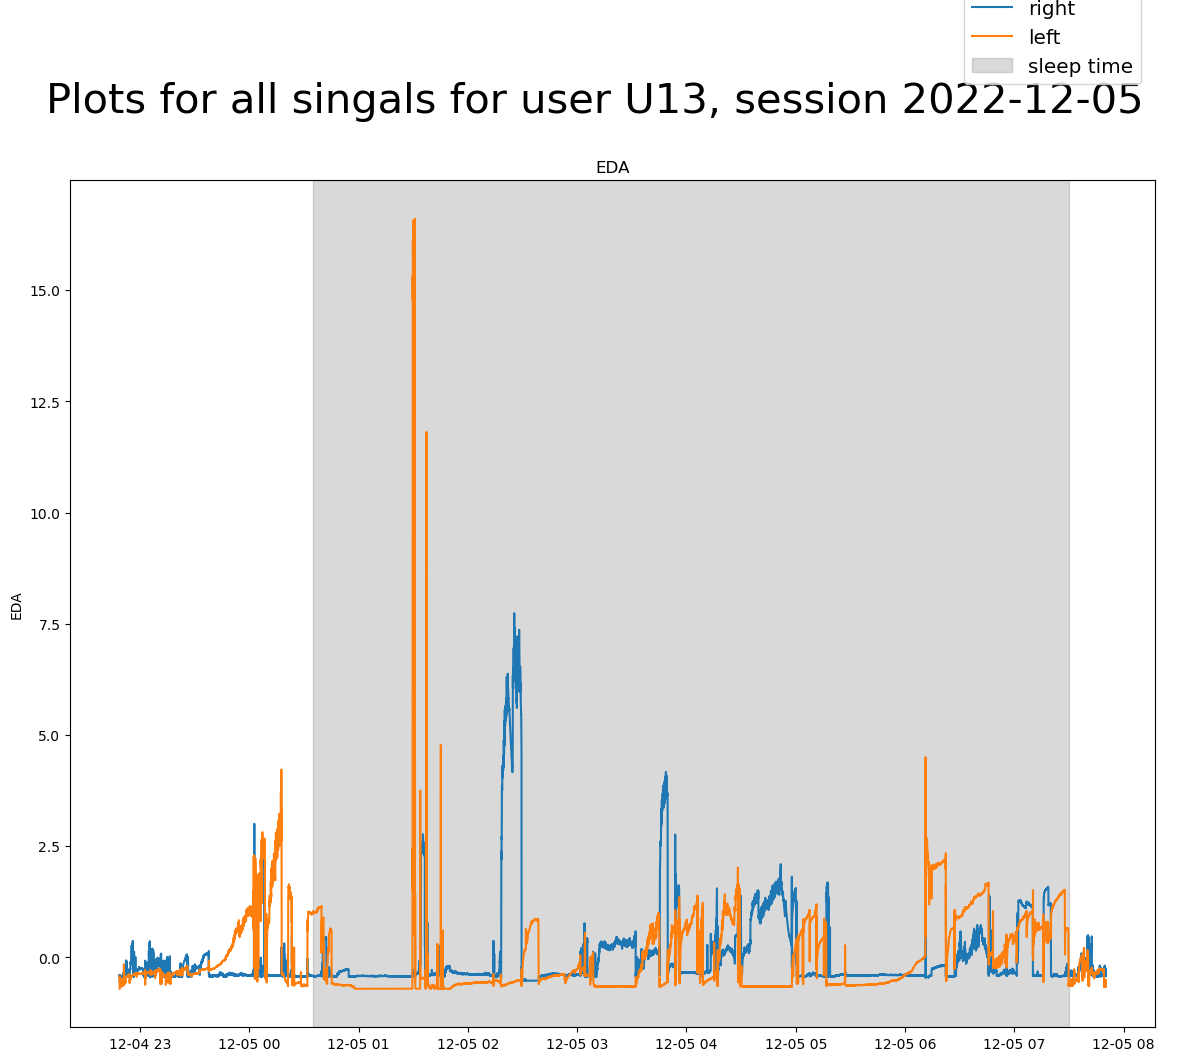

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

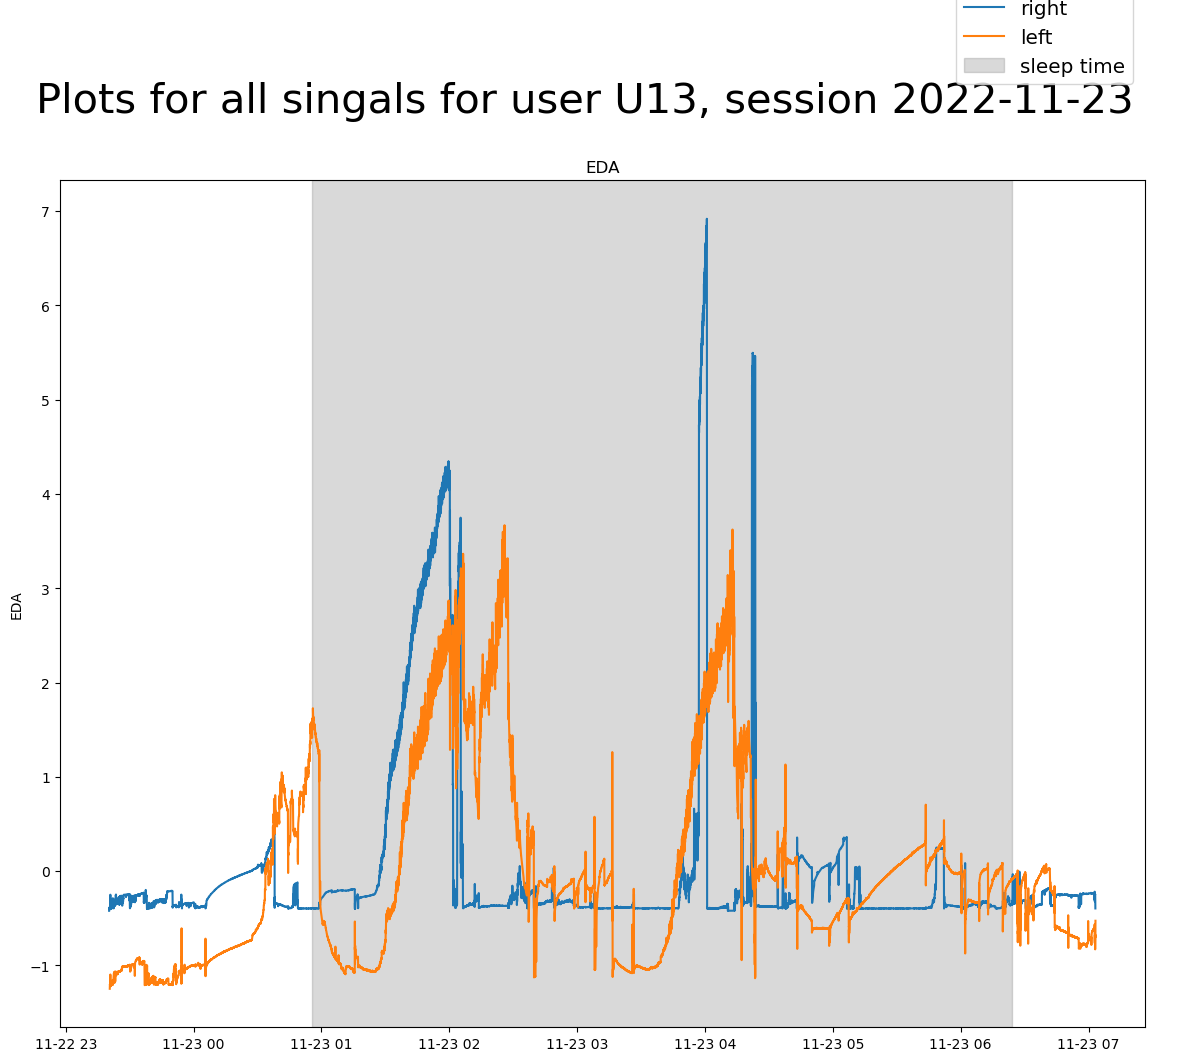

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

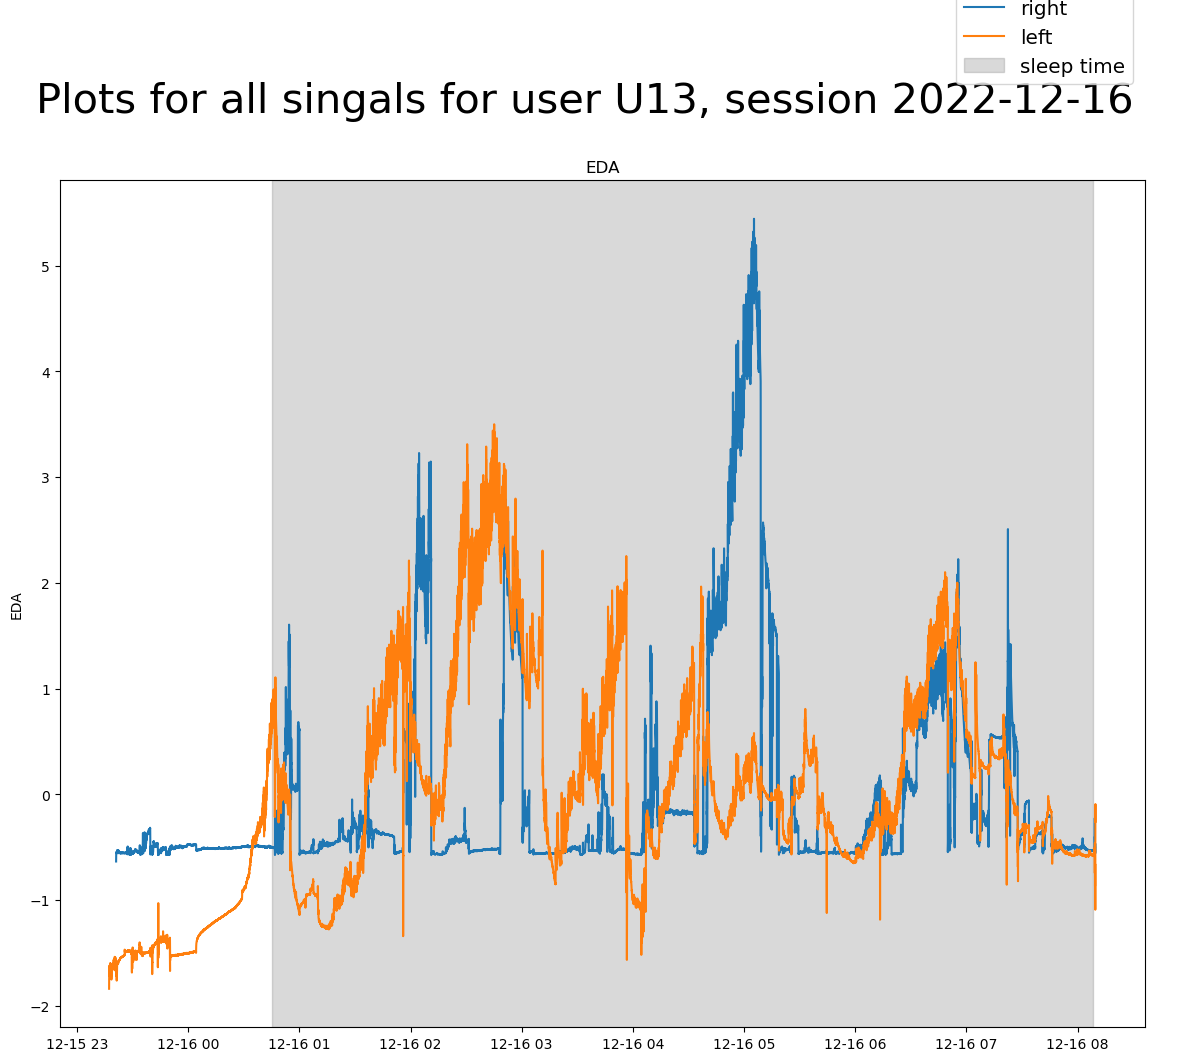

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

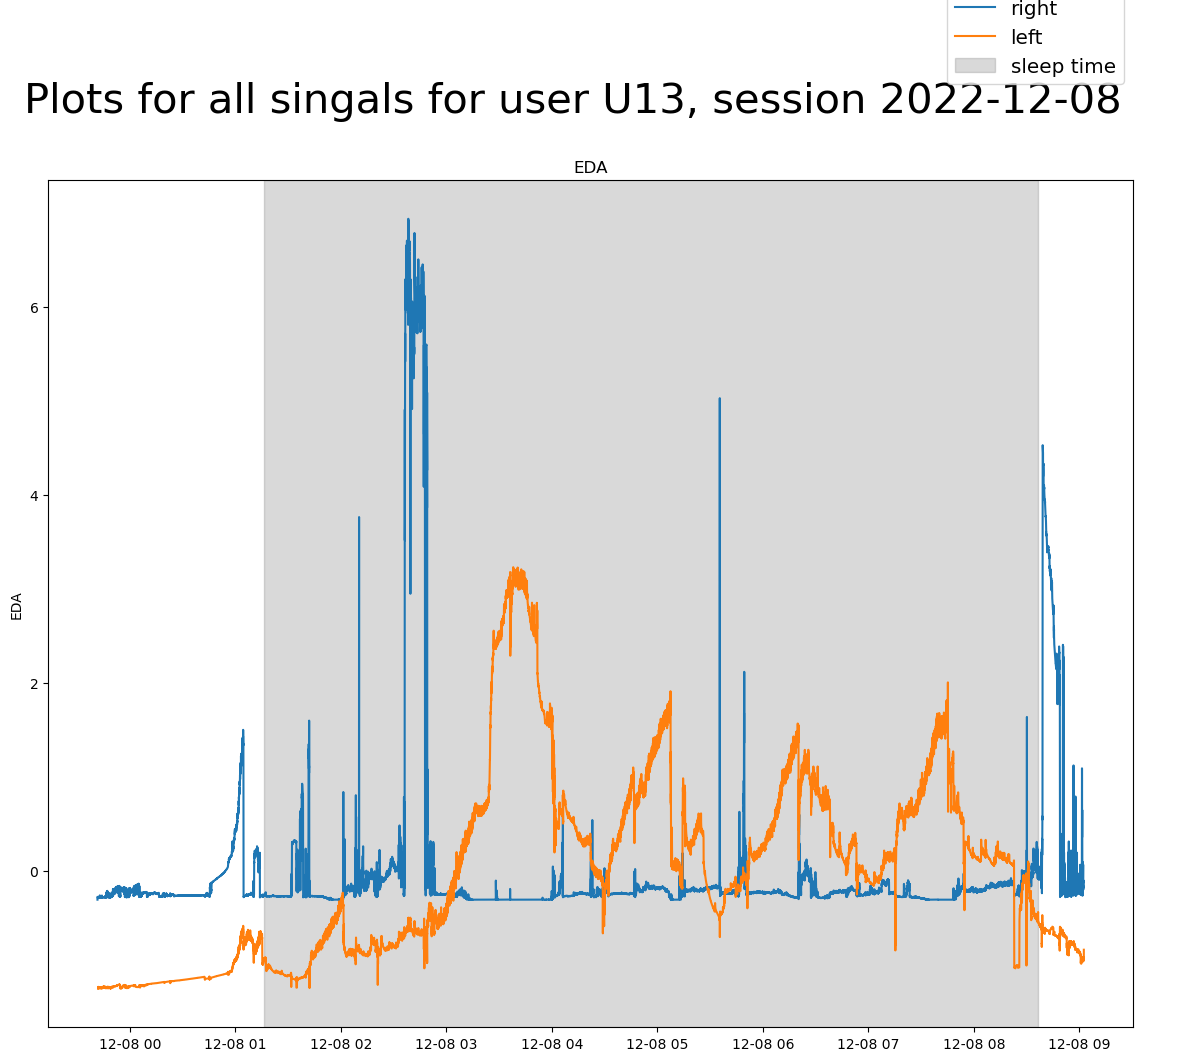

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

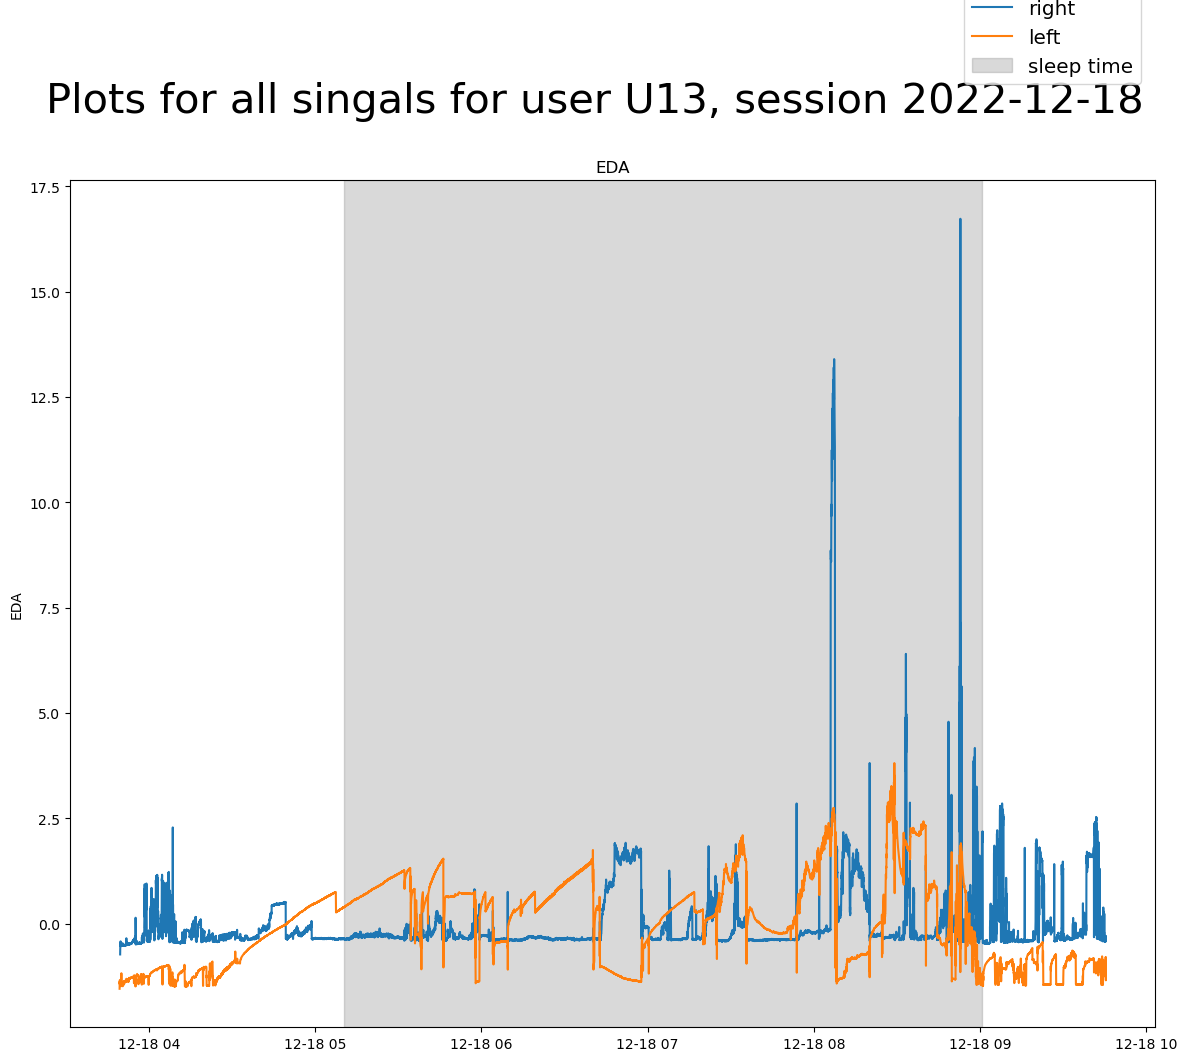

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

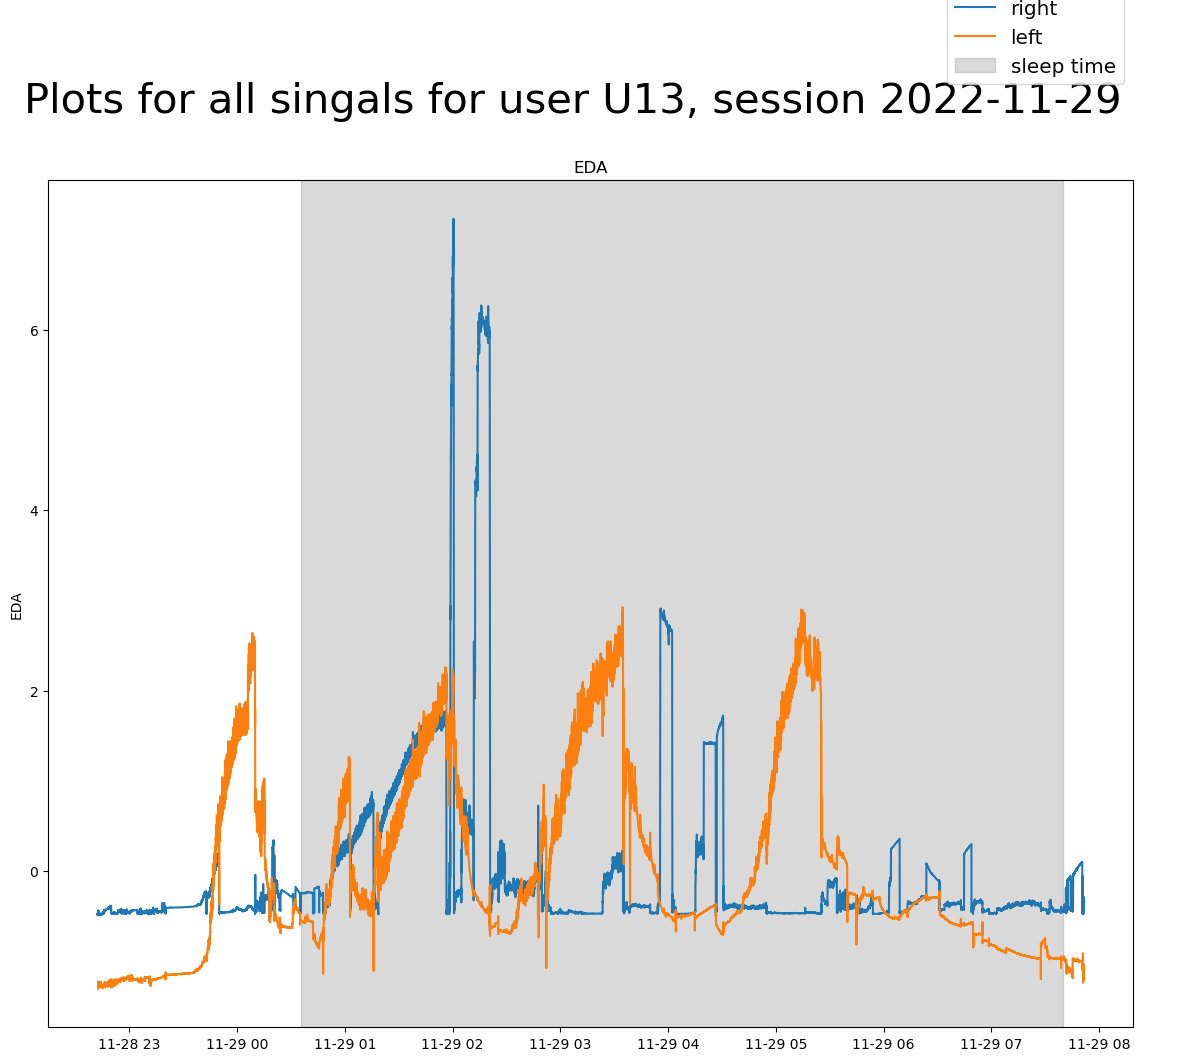

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

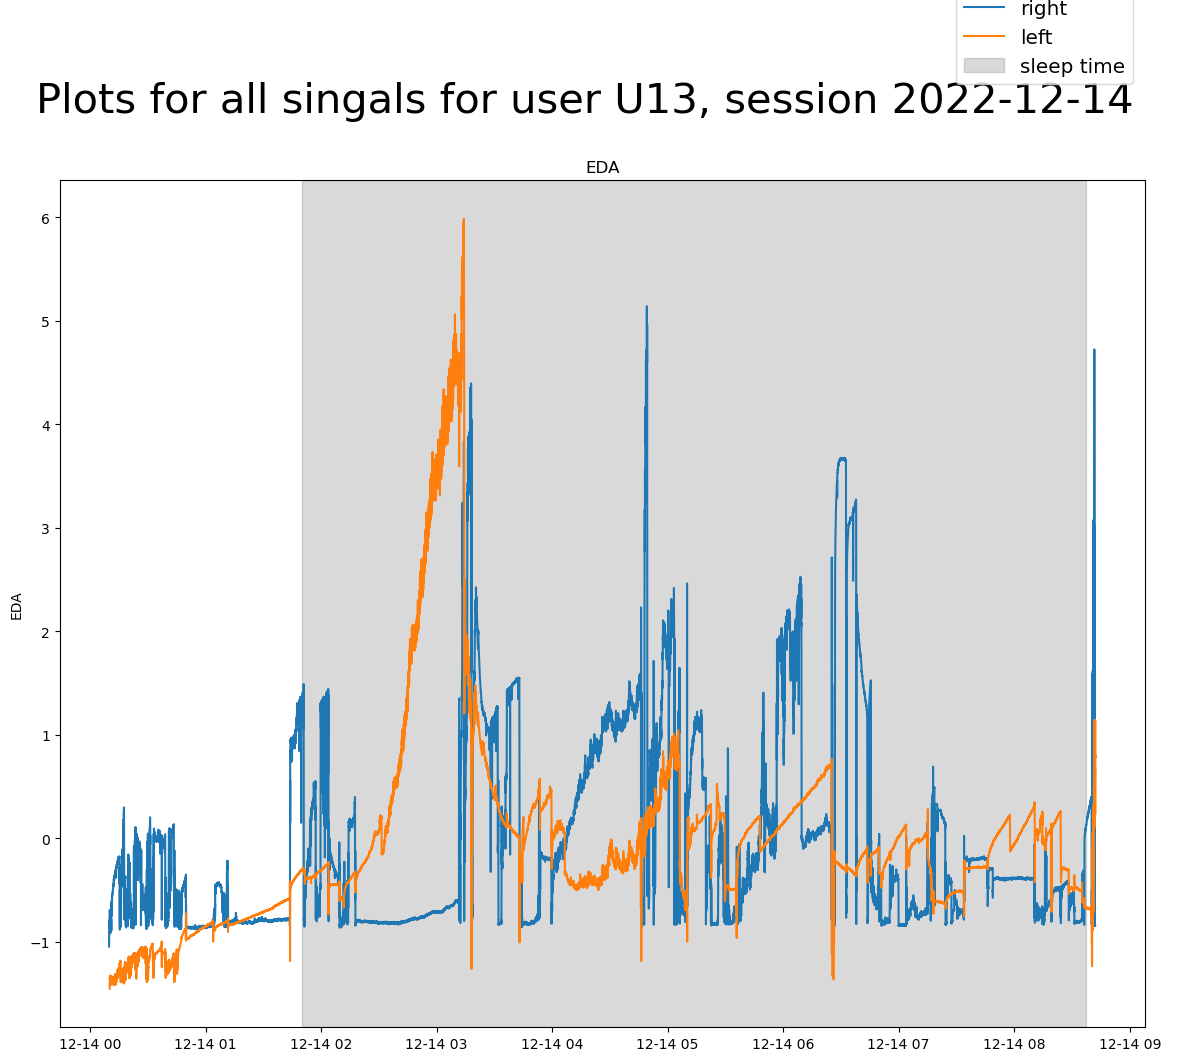

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

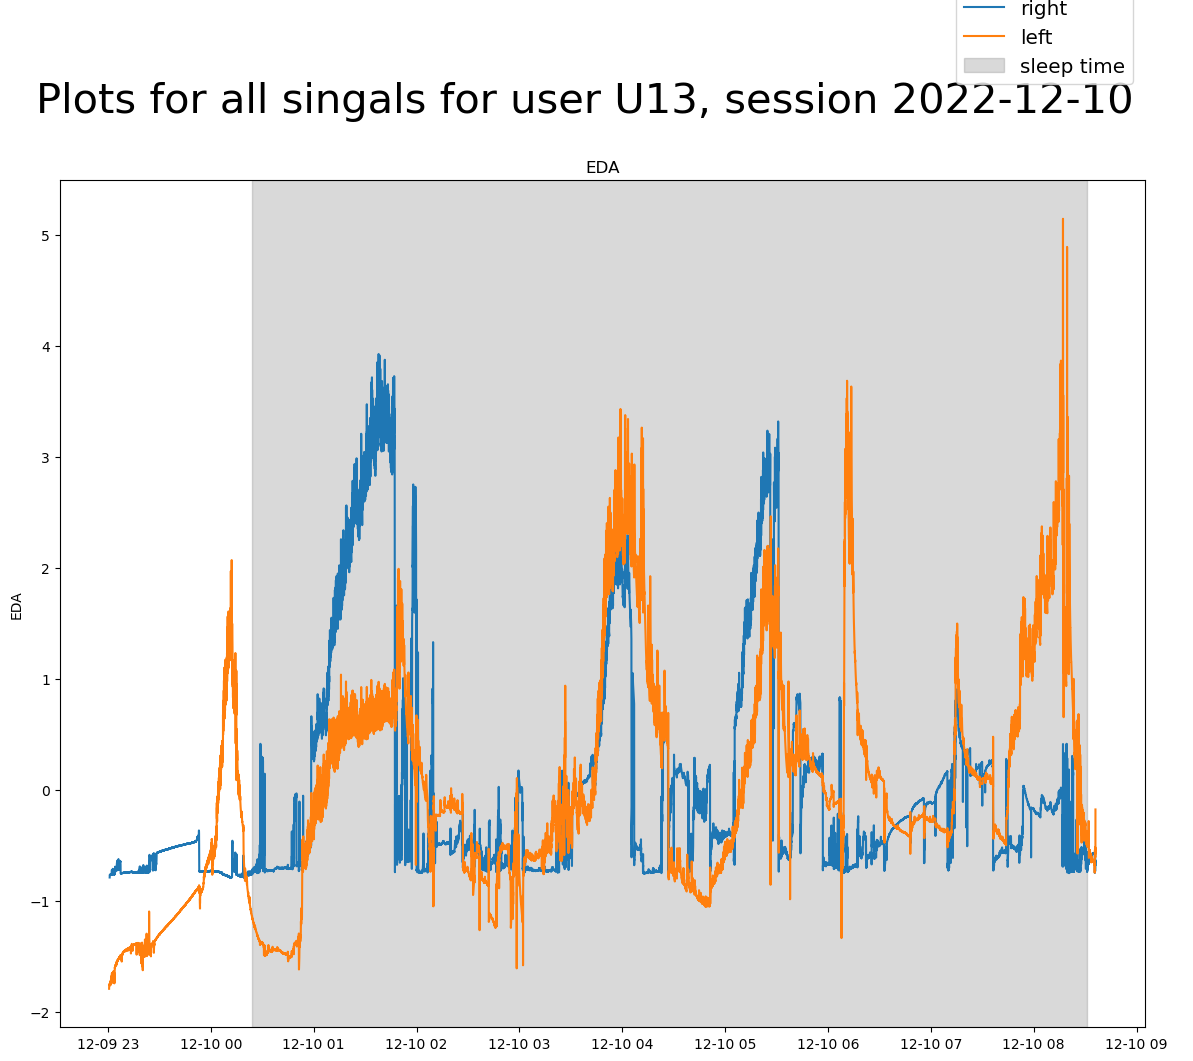

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

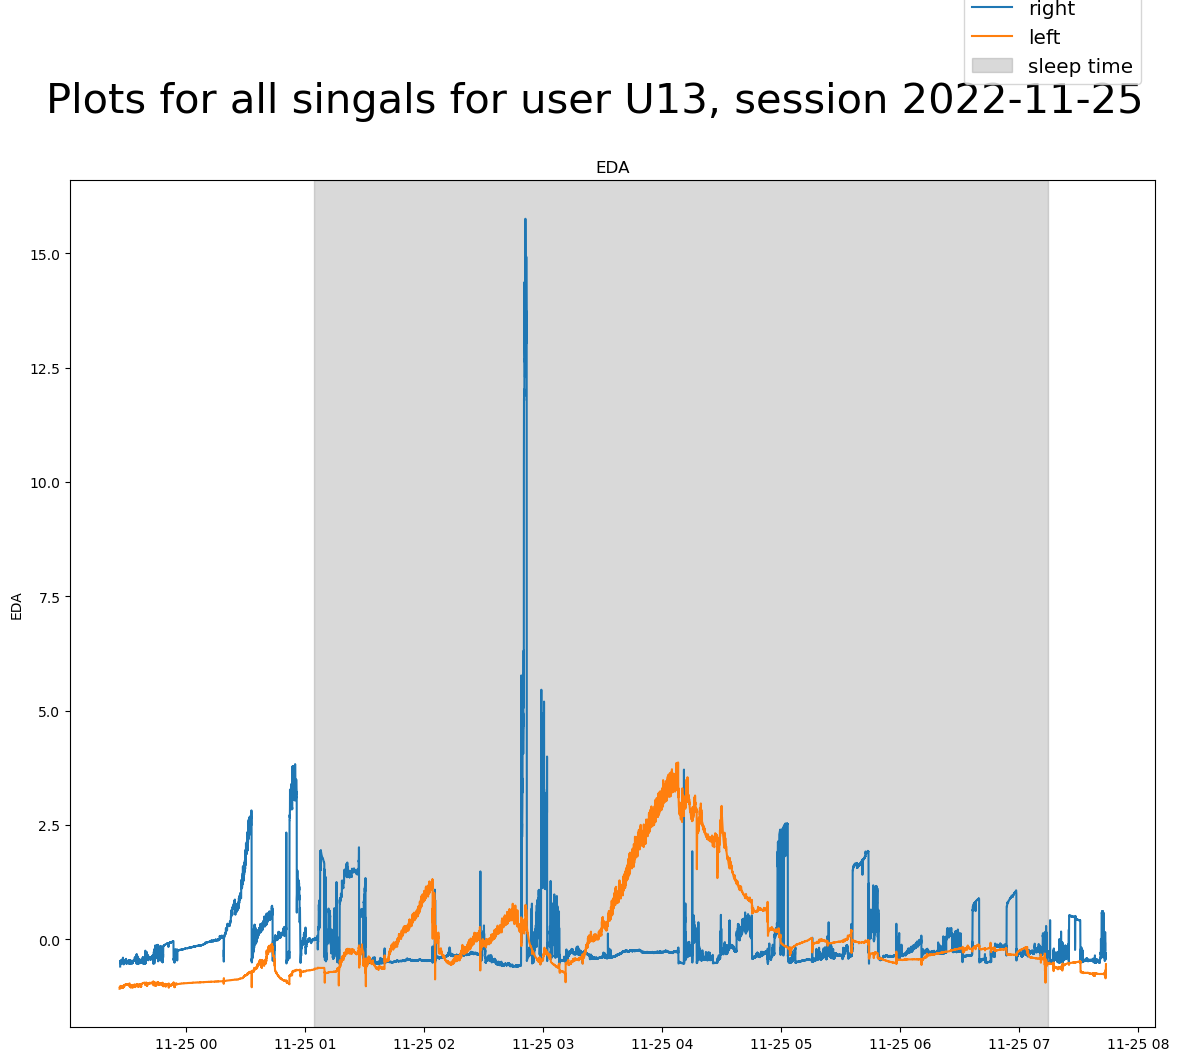

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

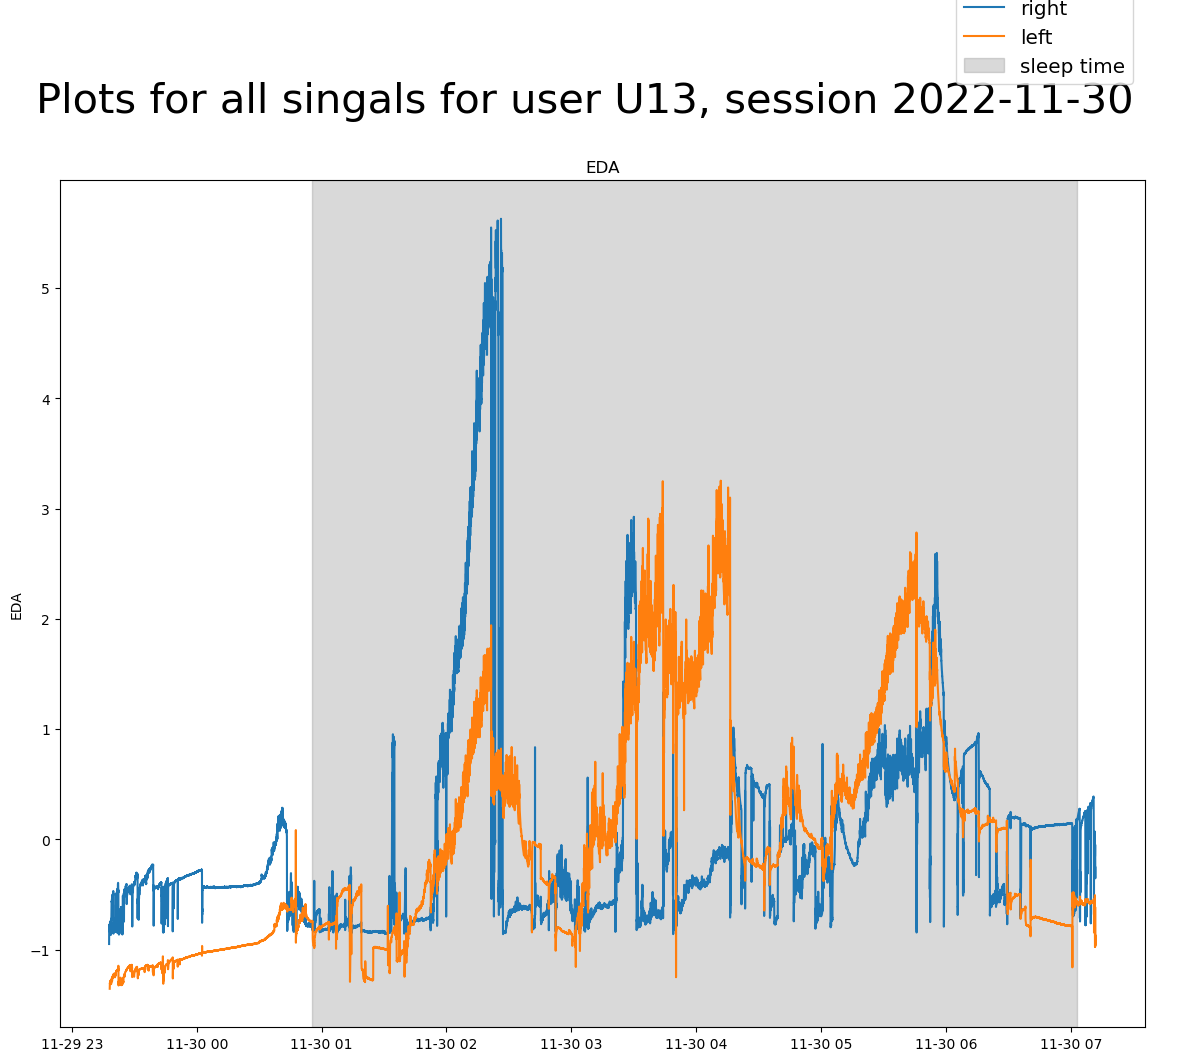

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

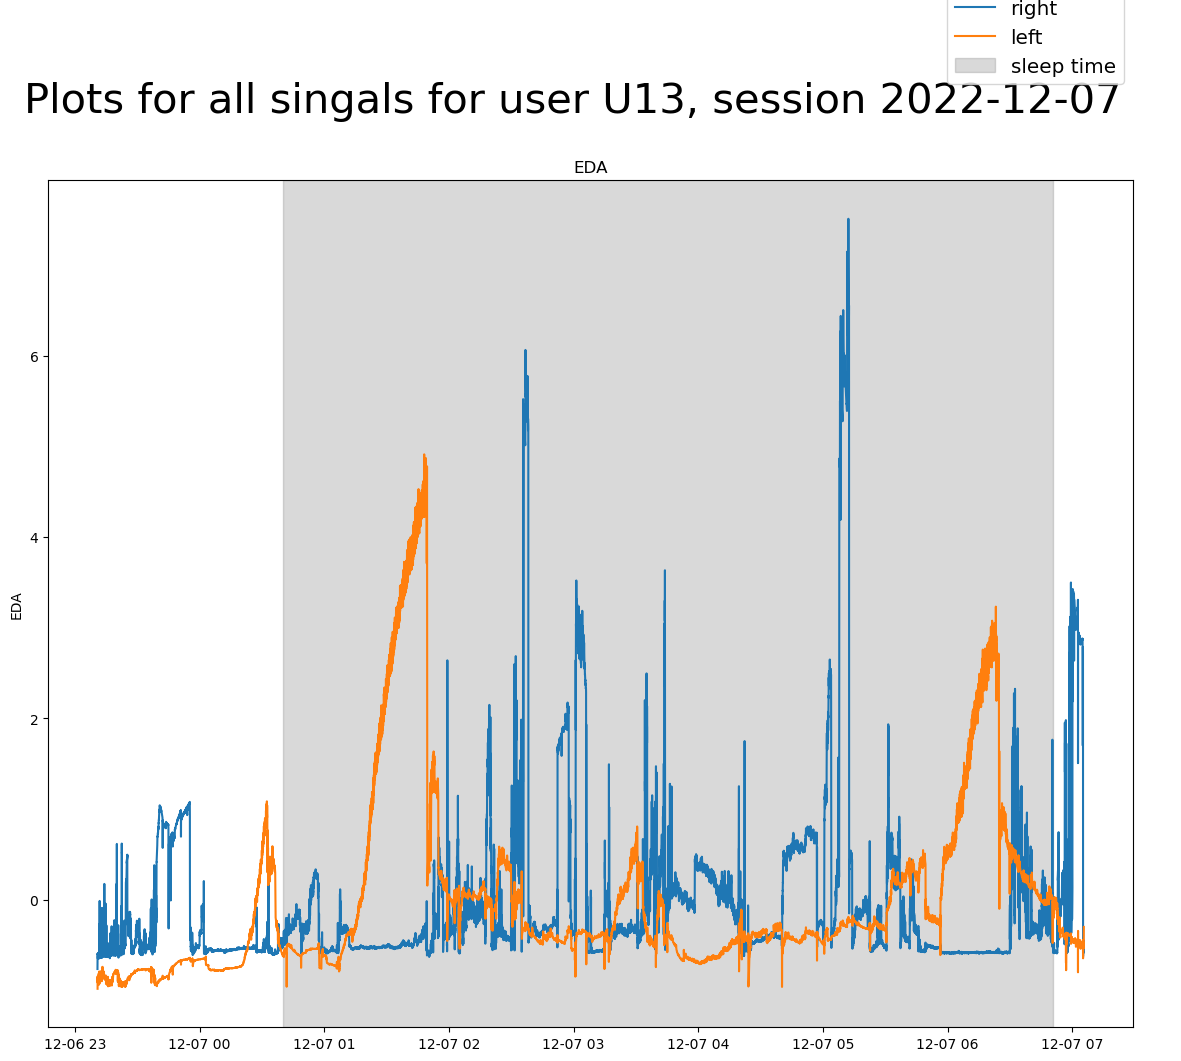

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

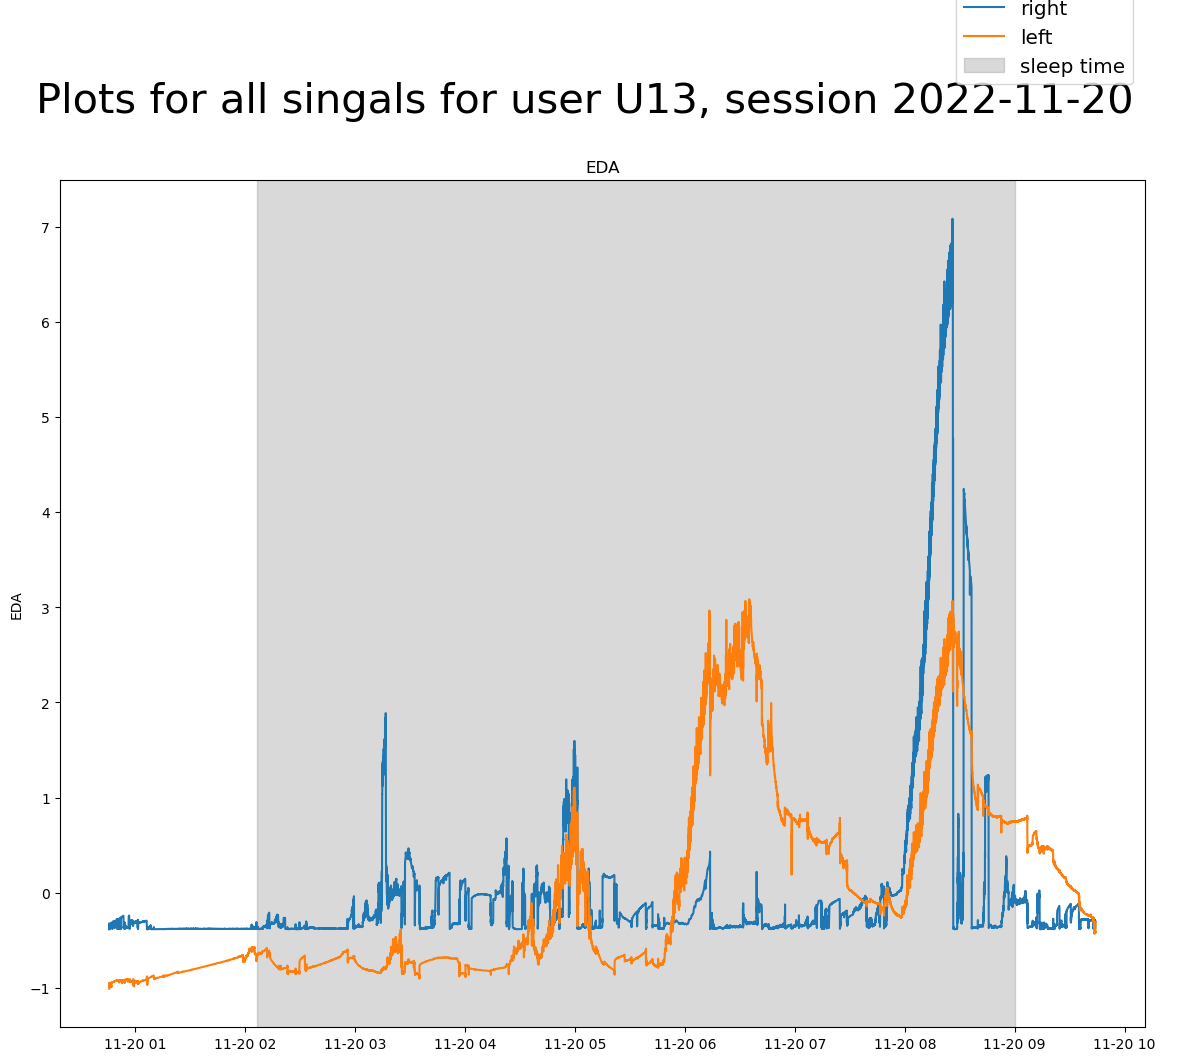

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

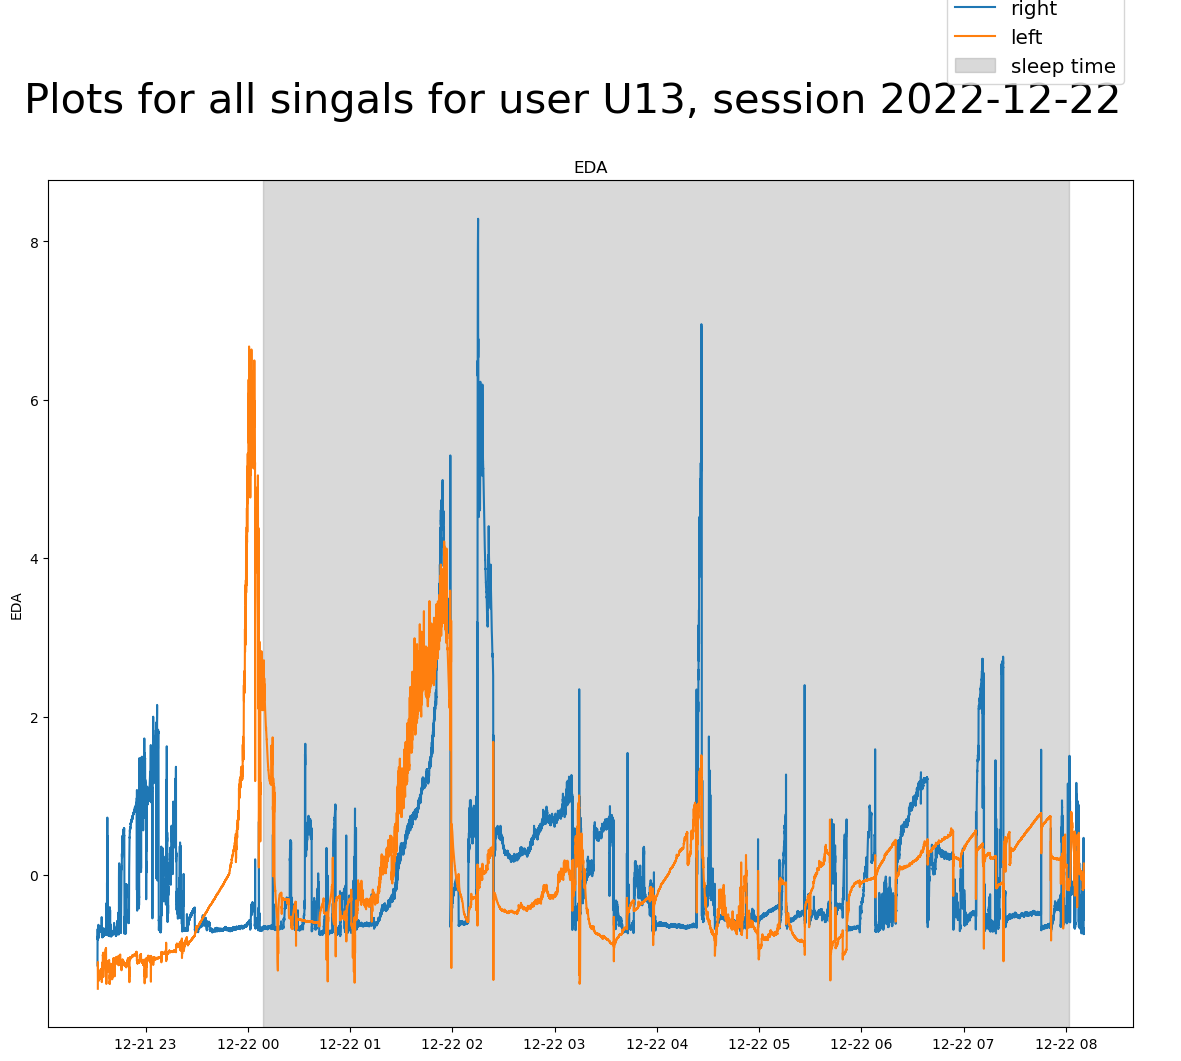

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

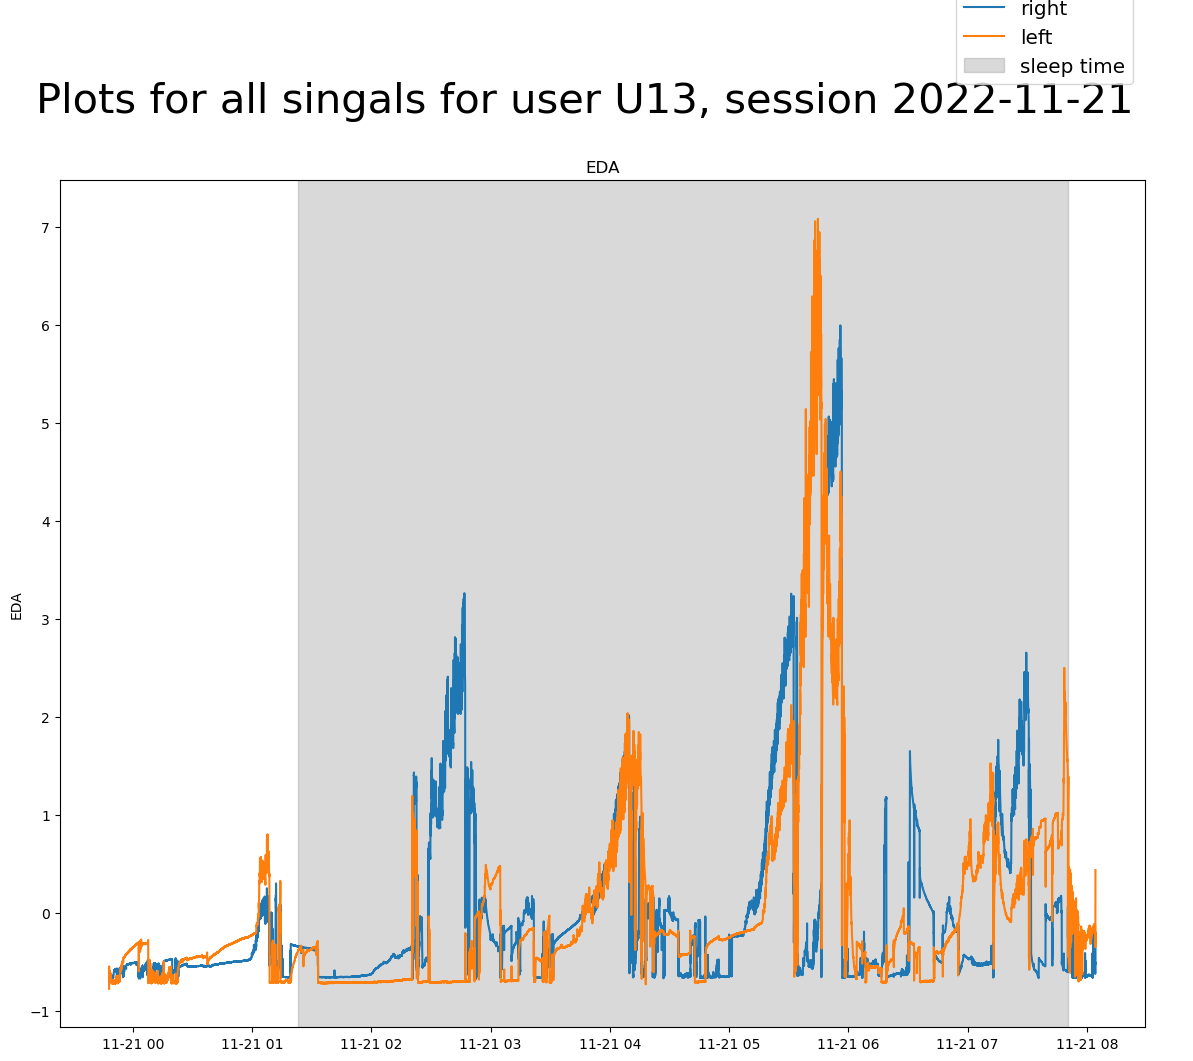

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

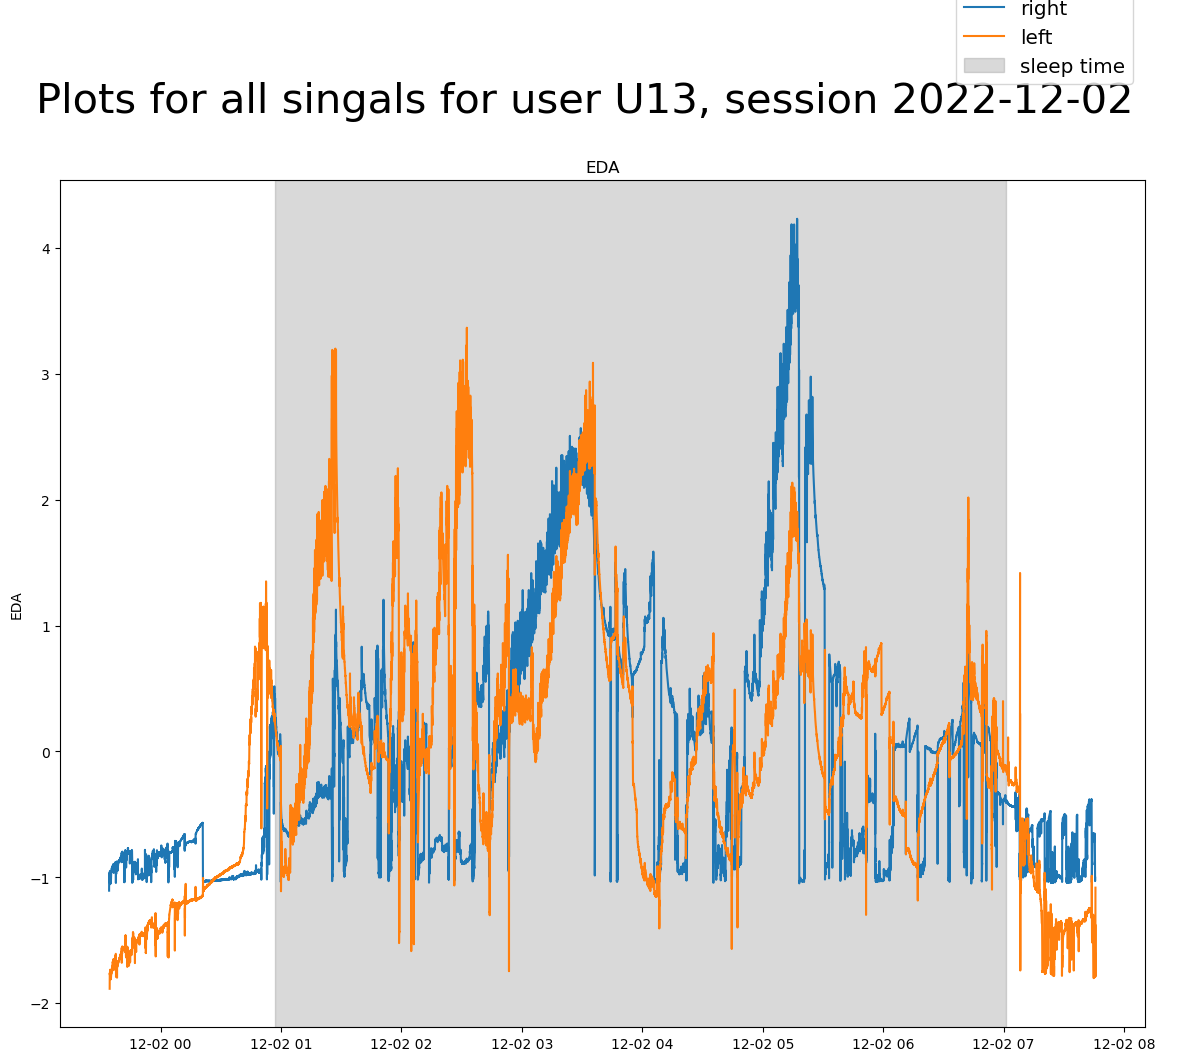

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

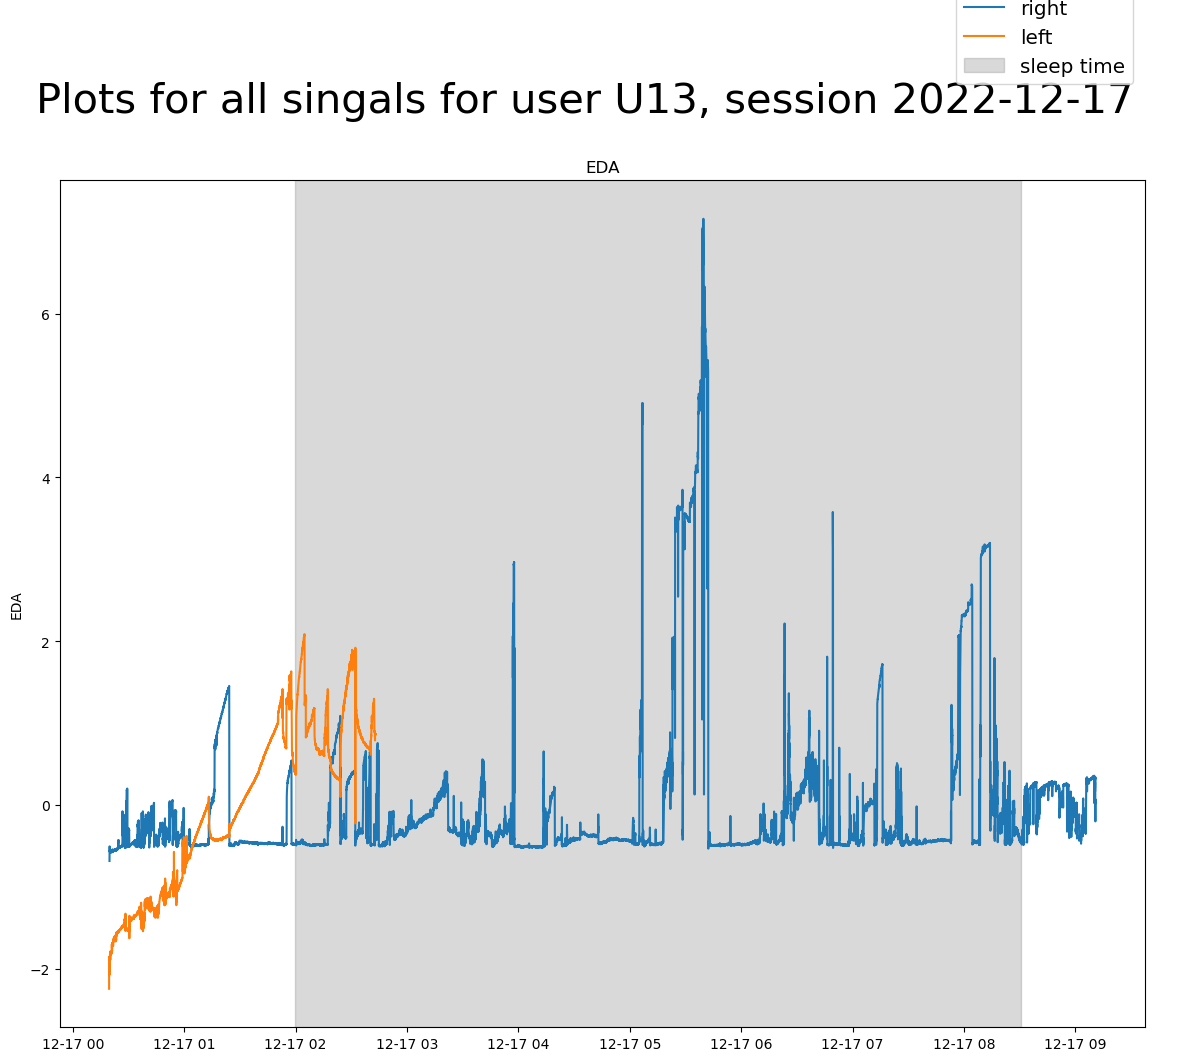

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

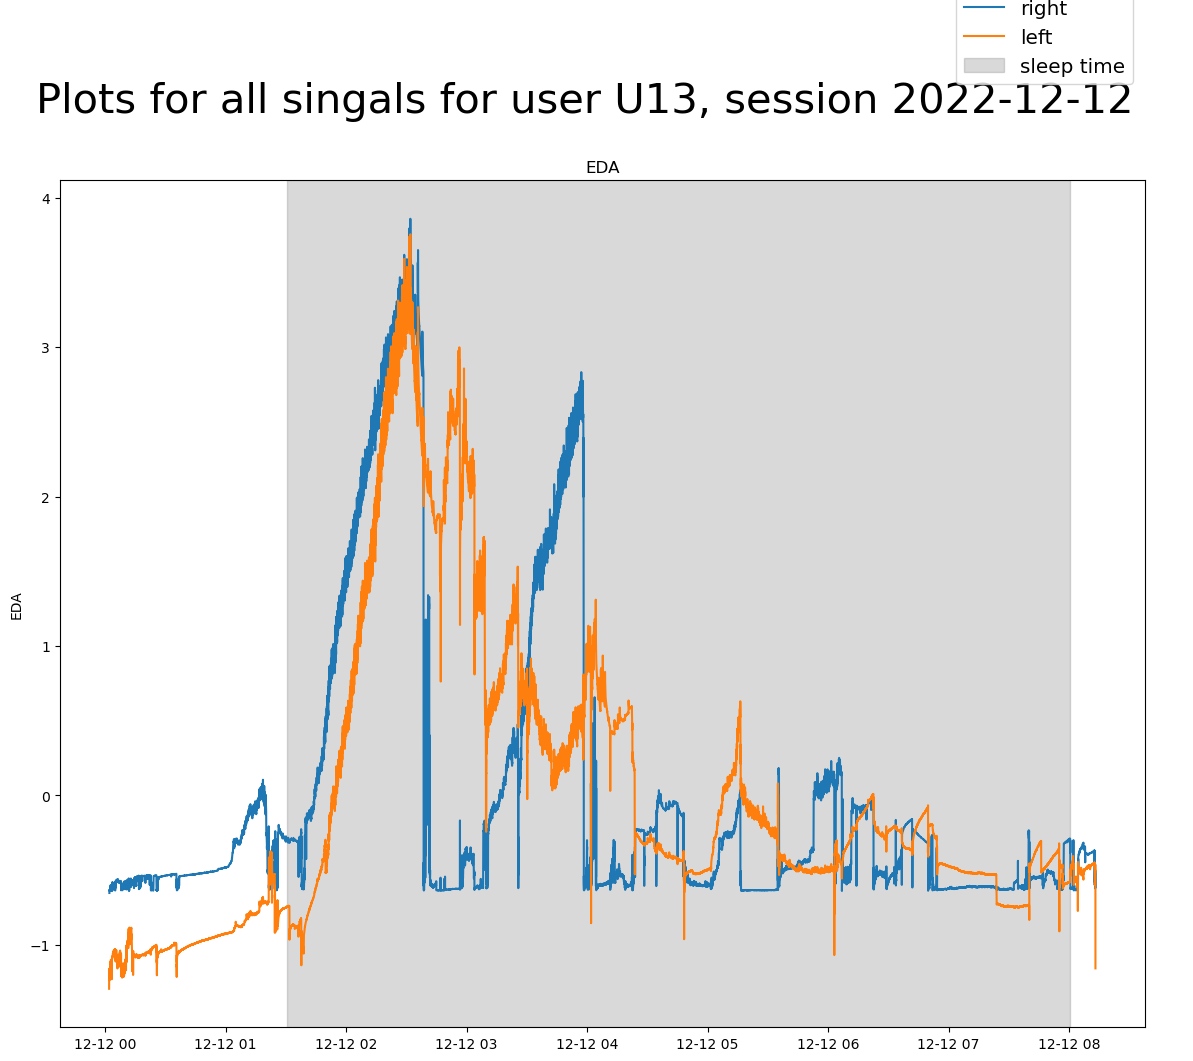

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

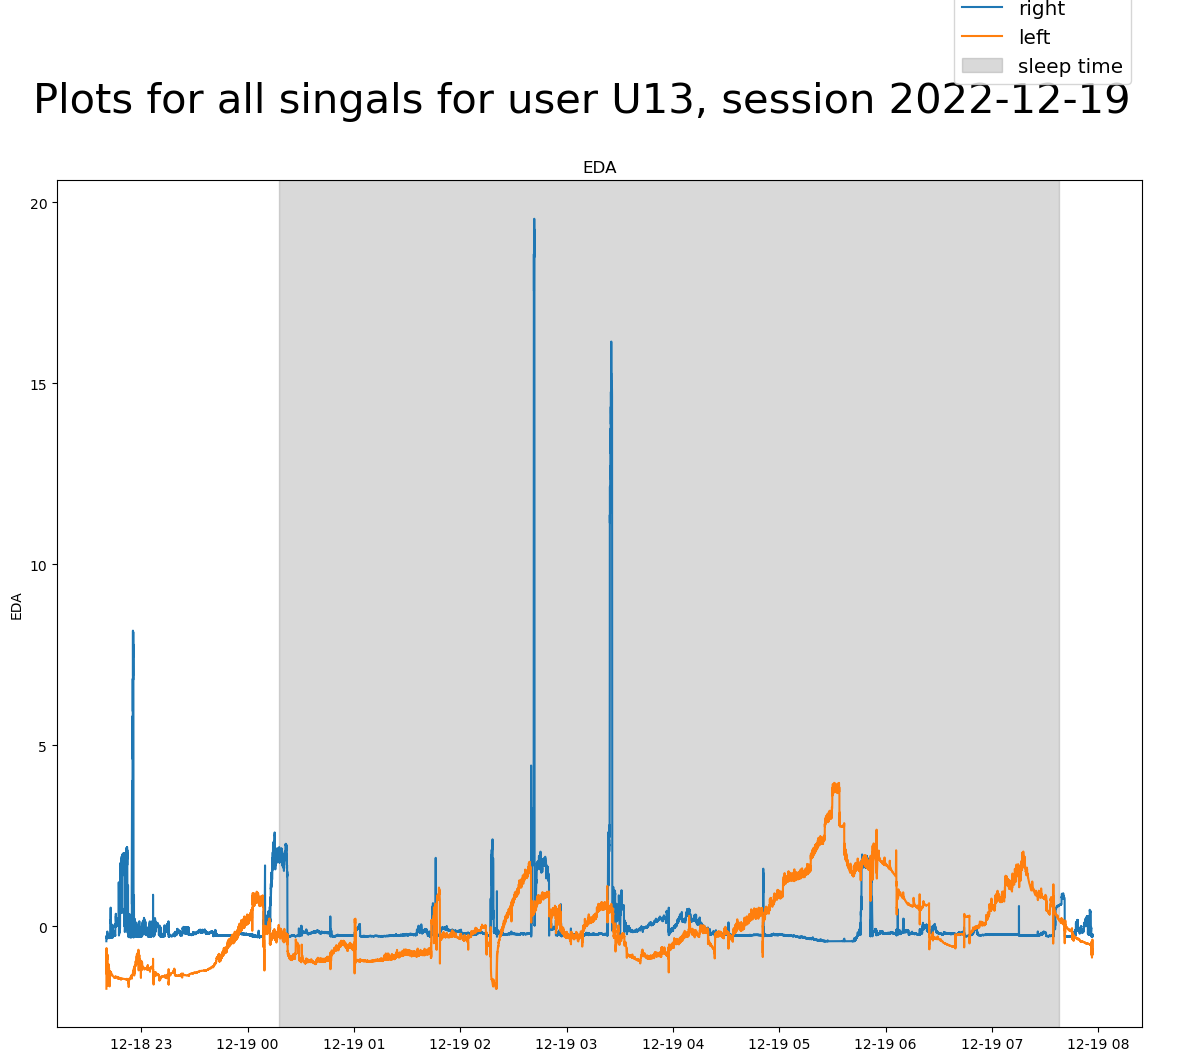

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

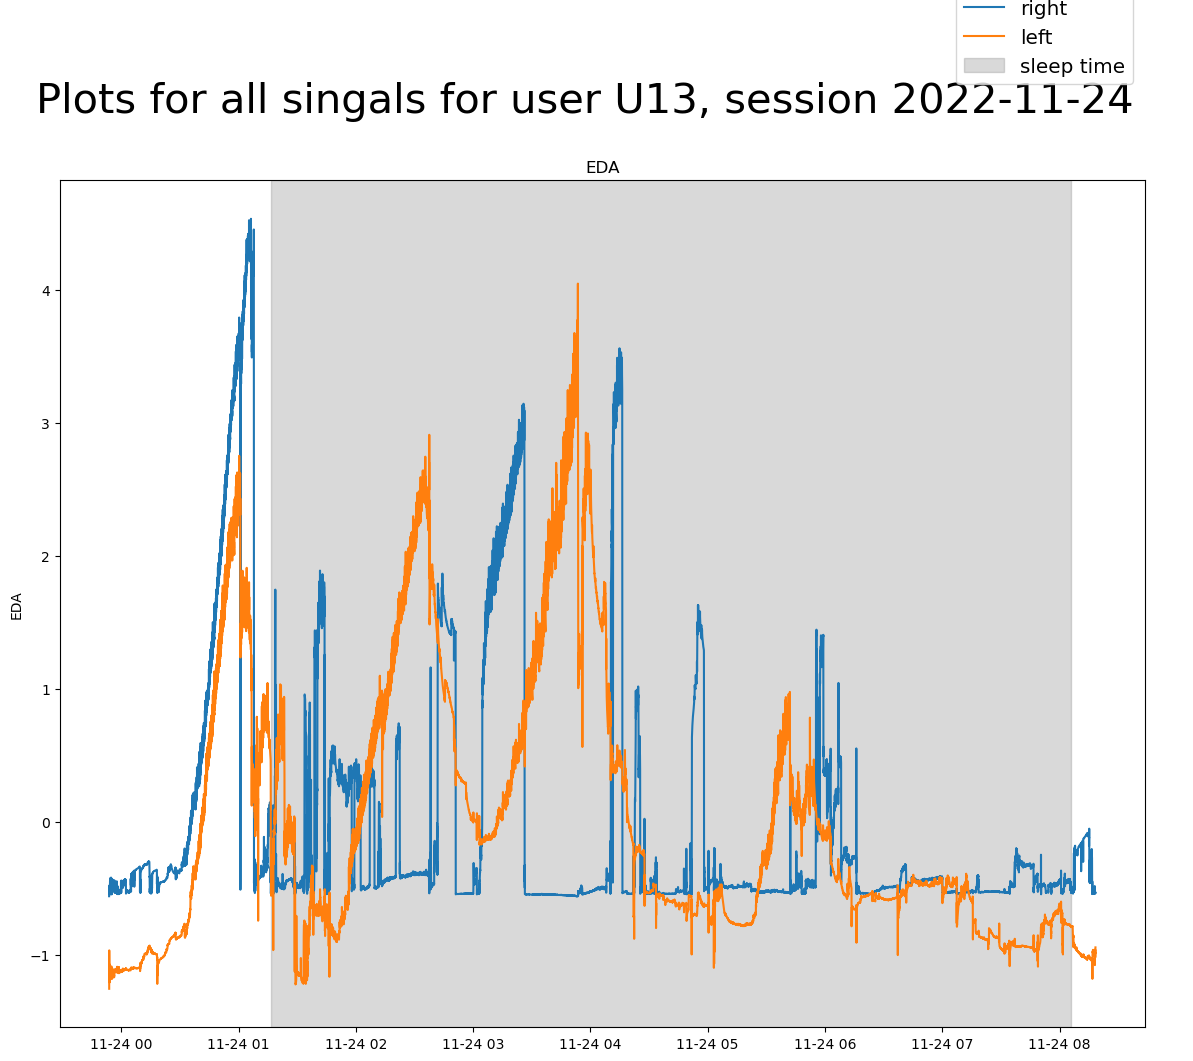

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

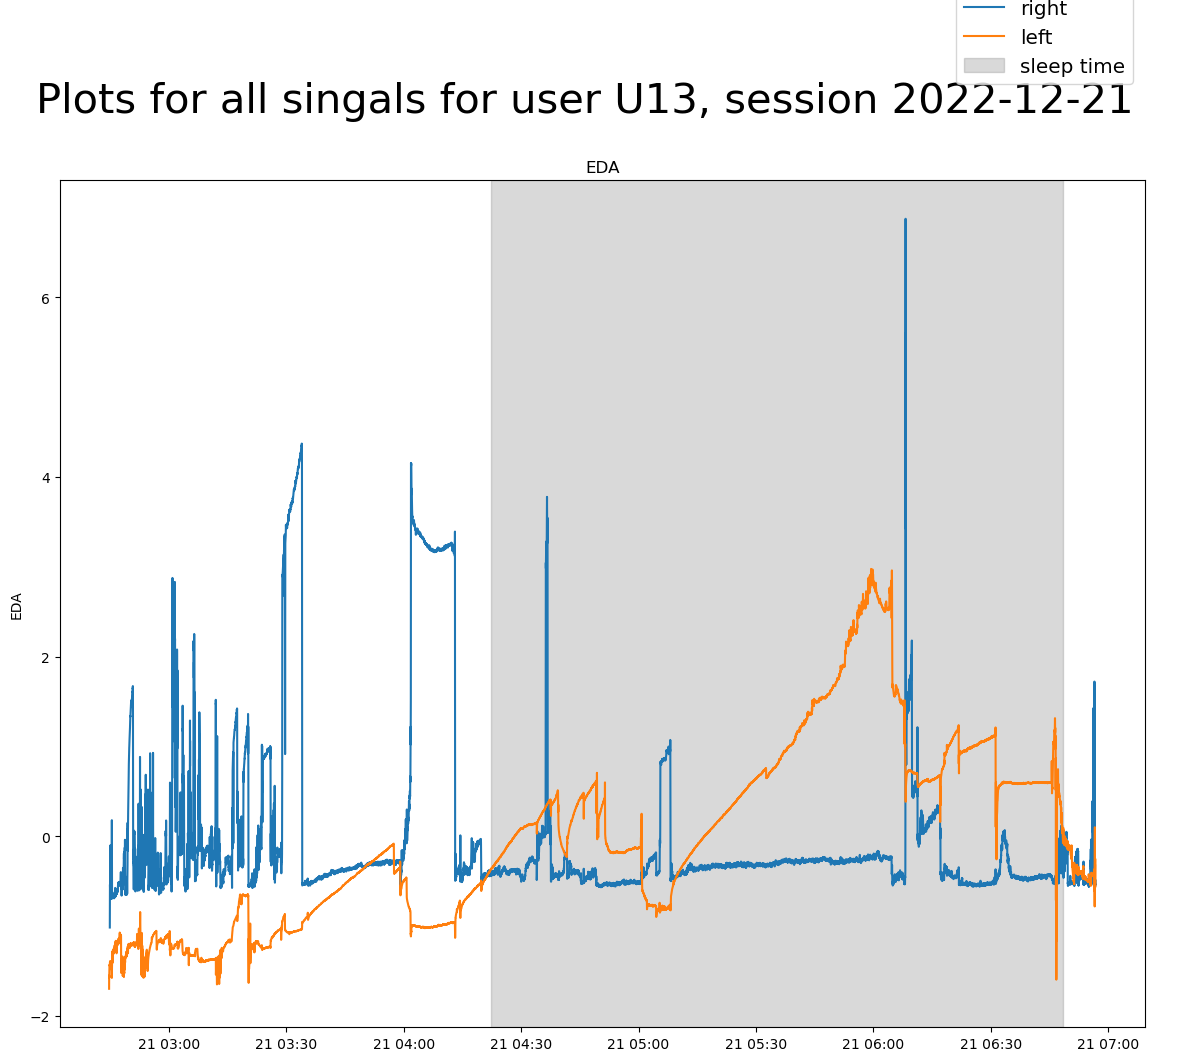

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

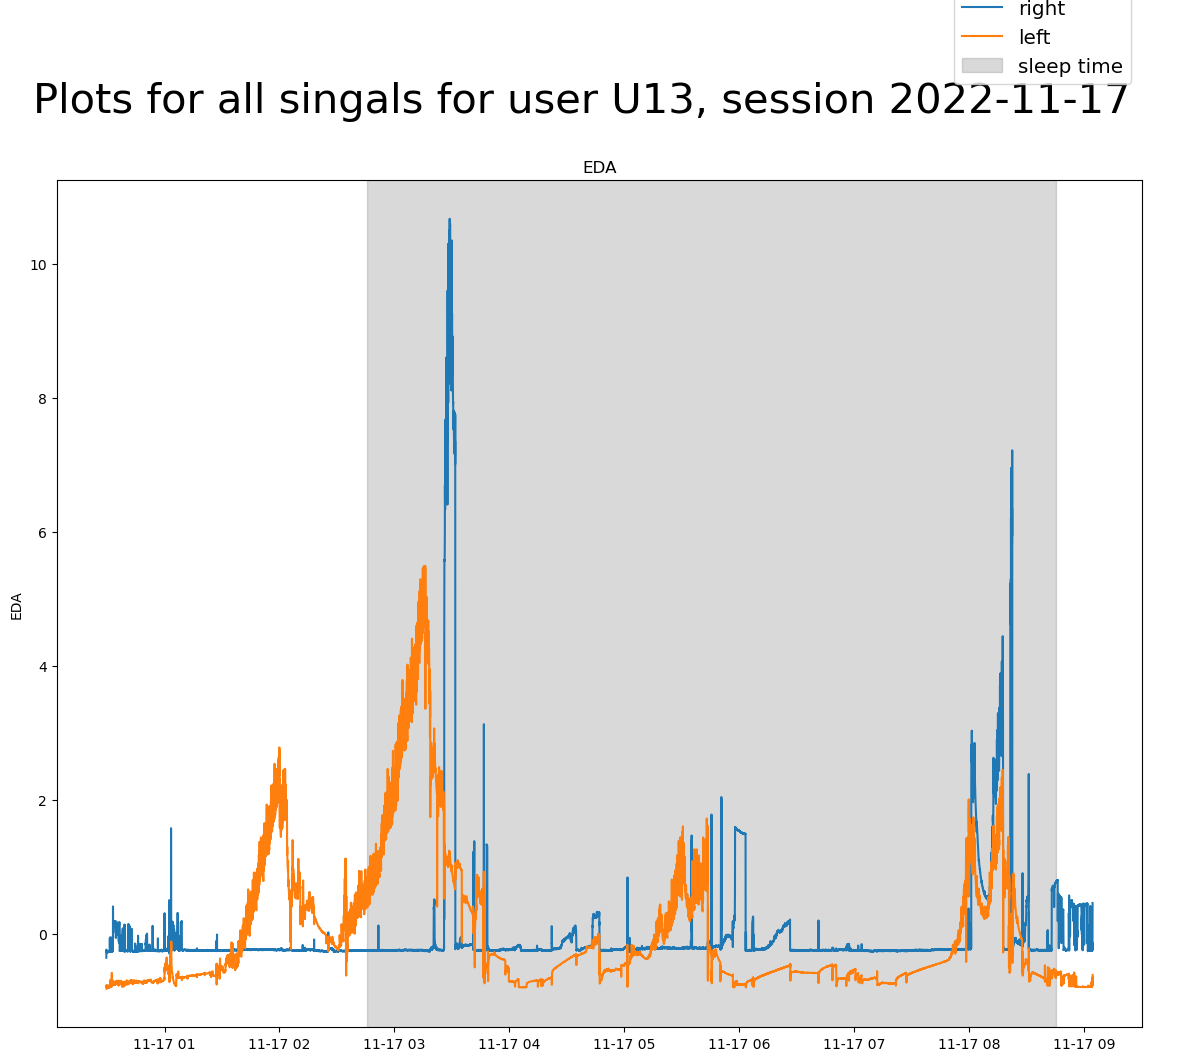

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

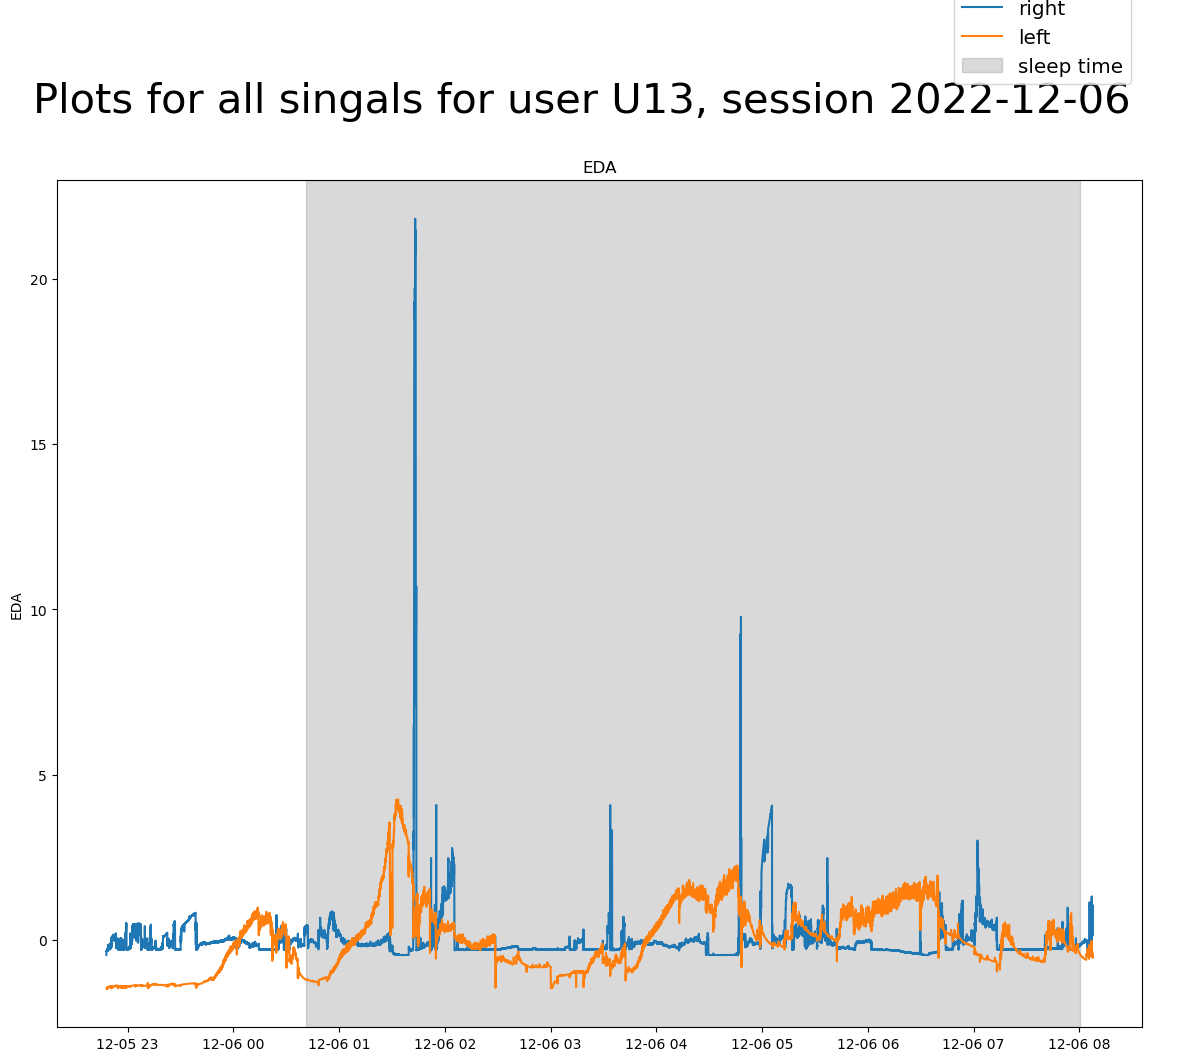

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

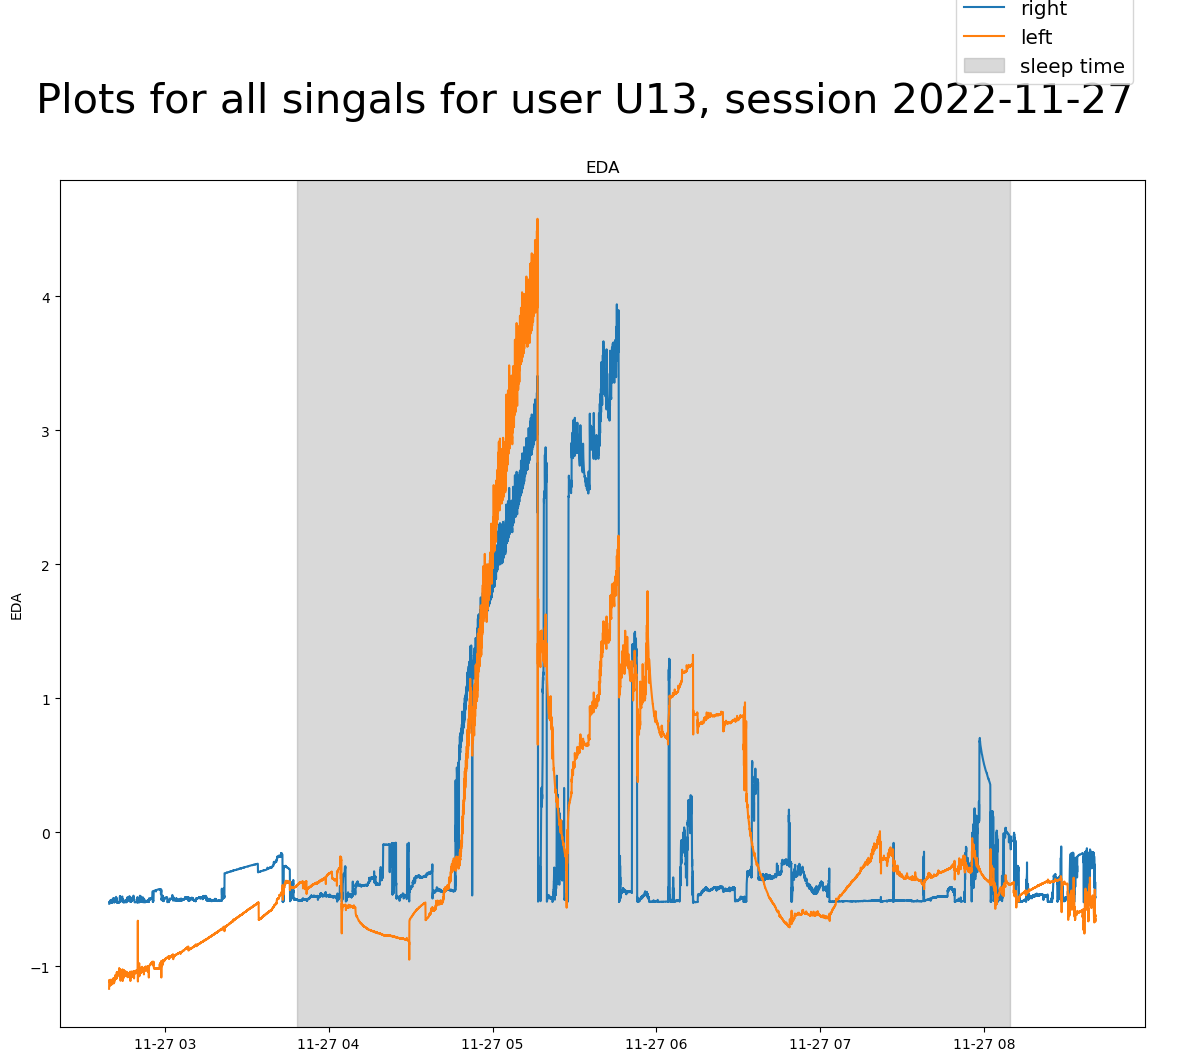

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

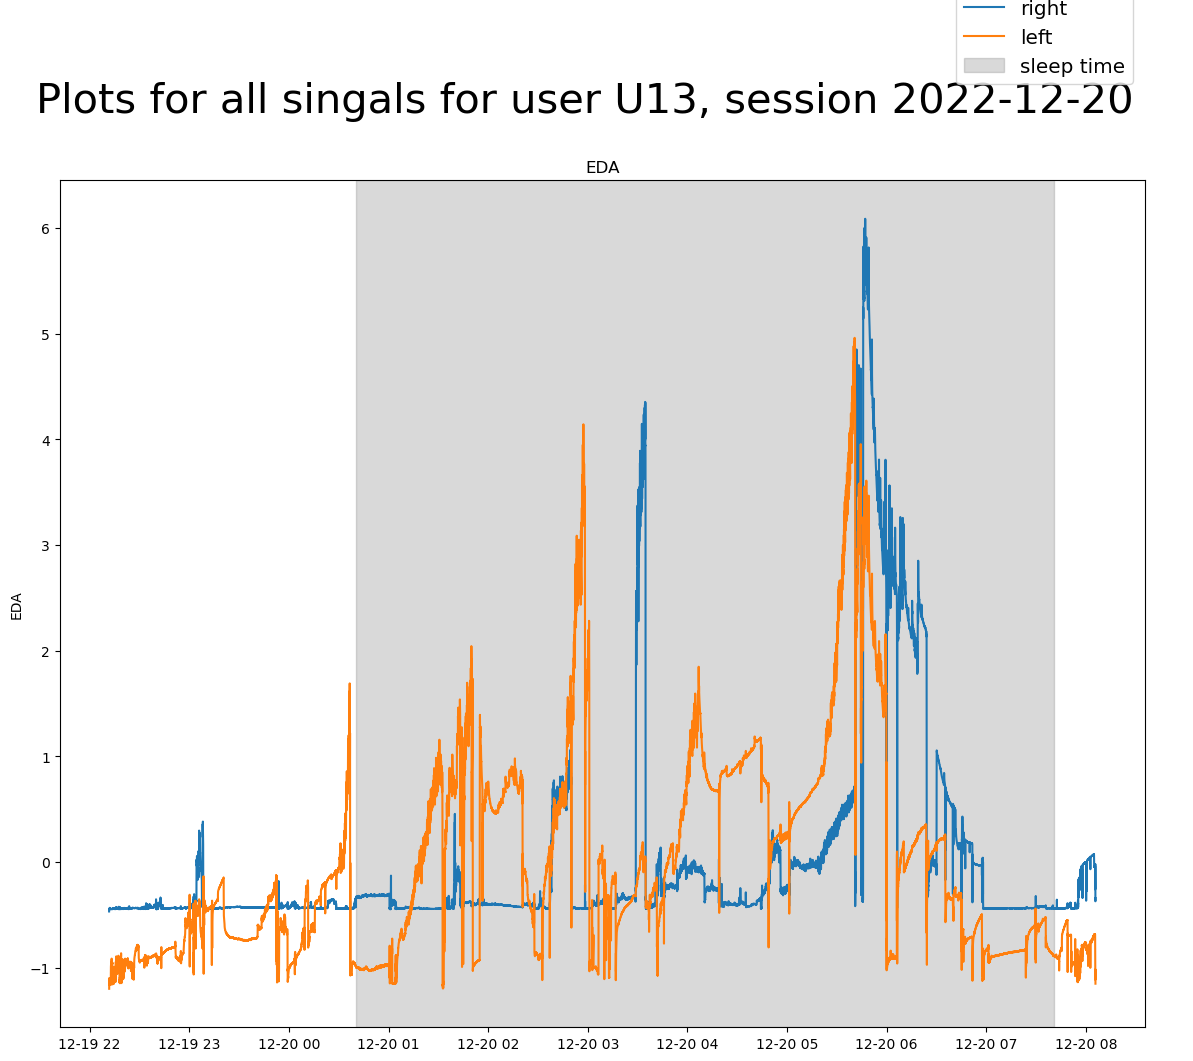

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

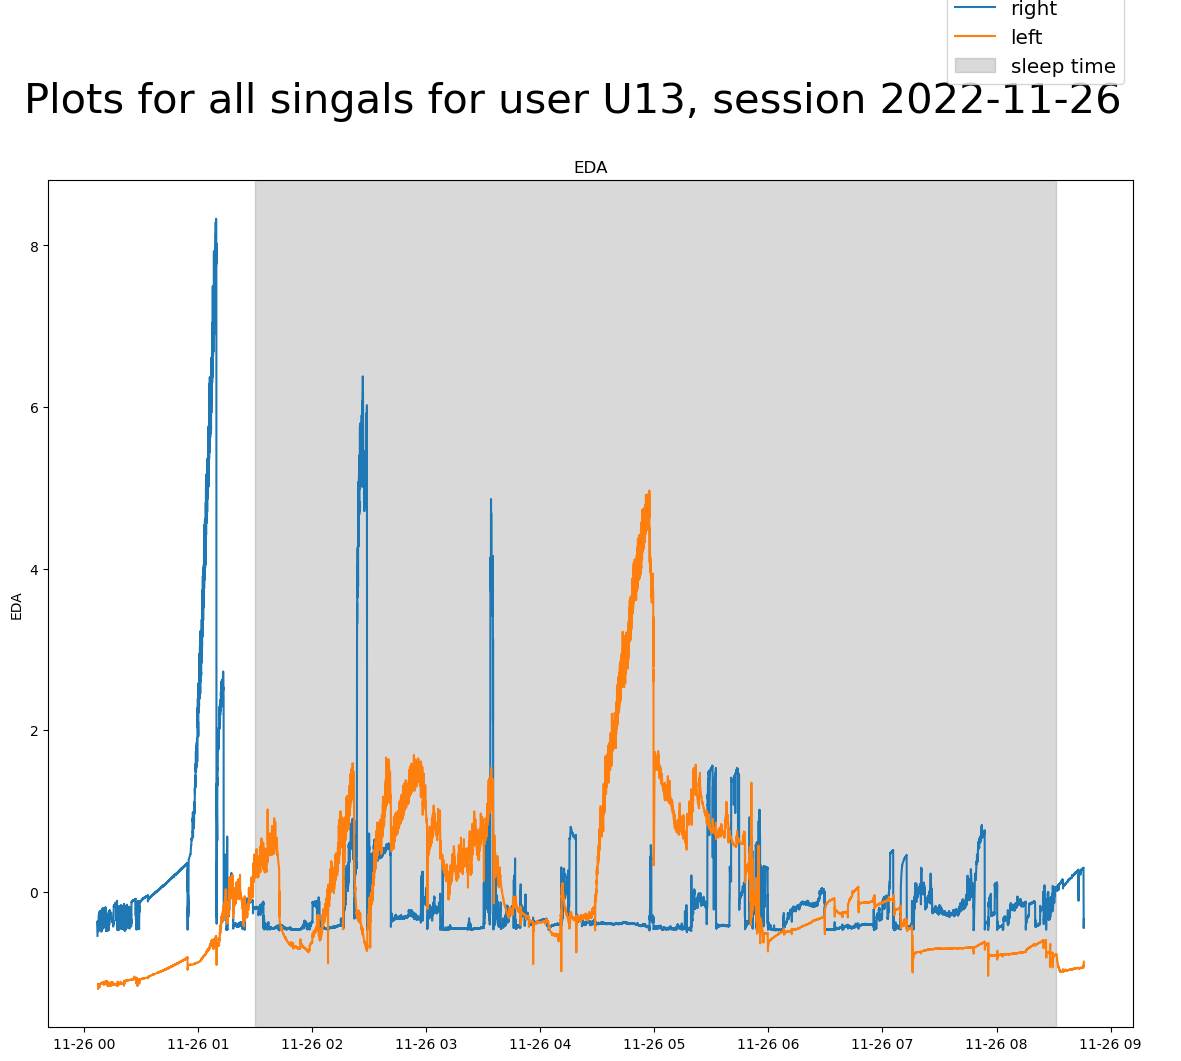

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

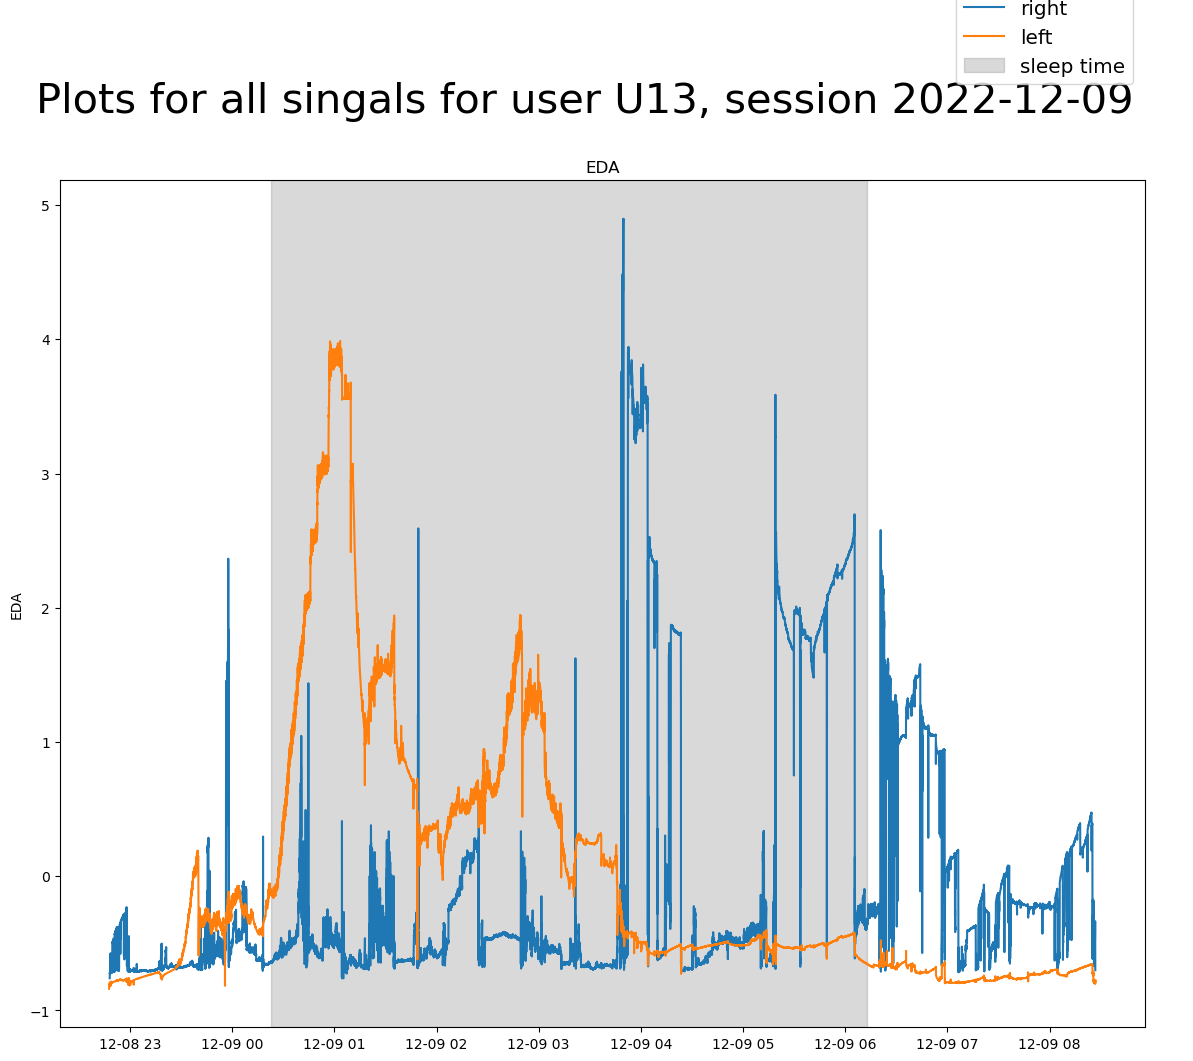

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

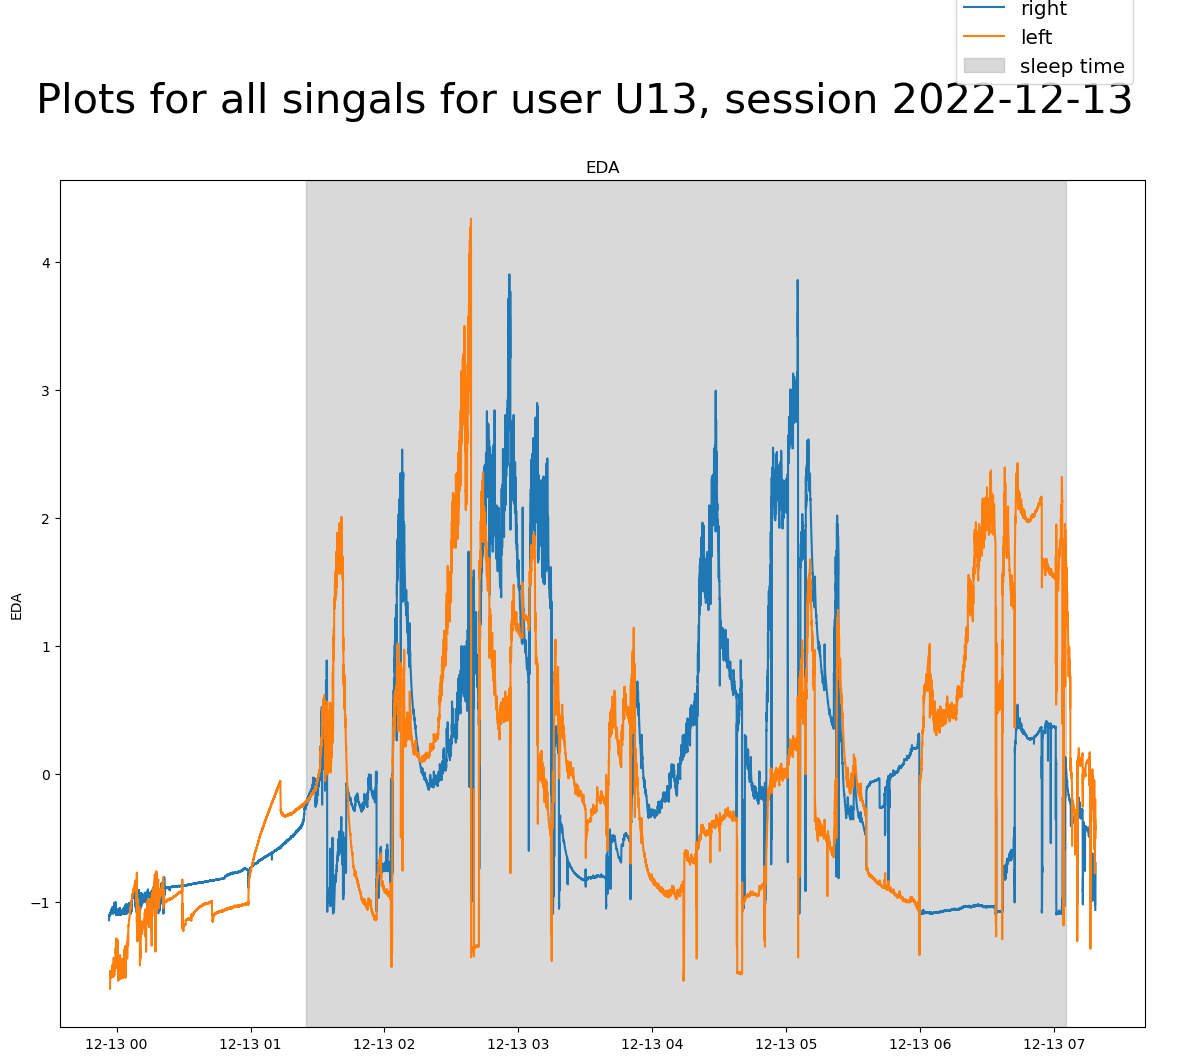

In [44]:
# session = session_selection.value
for session in sessions_all:
    make_biometrics_plots_together_matplotlib(
        data=physiological_data,
        user_id=user,
        session_id=session,
        experiment_info=experiment_info,
        eda_type="mixed-EDA",
    )


In [13]:
dataset_exloration = {}
for user in tqdm(sorted(users), desc='Exploring dataset'):
    sessions_right = physiological_data["EDA"]["left"][user].index.get_level_values(0).unique()
    sessions_left = physiological_data["EDA"]["right"][user].index.get_level_values(0).unique()
    sessions = list(set(sessions_right) & set(sessions_left))
    
    if user not in experiment_info.index.get_level_values(0).unique():
        print(f'{user} not in experiment info. Skipping')
        continue
    morning_survey_sessions = experiment_info.loc[IndexSlice[user, :], :].index.get_level_values(1).unique()
    
    sessions_all = list(set(sessions) & set(morning_survey_sessions))
    dataset_exloration[user] = {'lx & rx': len(sessions), 
                                'lx': len(sessions_left),
                                'rx': len(sessions_right),
                                'm_survey': len(morning_survey_sessions),
                                'lx & rx & m_survey': len(sessions_all),
                                }
    


Exploring dataset:   0%|          | 0/8 [00:00<?, ?it/s]

In [14]:
dataset_exloration = DataFrame(dataset_exloration)
display(dataset_exloration)

,U01,U02,U03,U04,U06,U09,U10,U13
lx & rx,12,0,17,14,8,19,7,33
lx,13,1,17,15,9,22,10,36
rx,12,19,17,14,11,19,8,33
m_survey,18,23,24,18,8,22,25,34
lx & rx & m_survey,10,0,16,11,4,19,7,30


<AxesSubplot:ylabel='lx & rx & m_survey'>

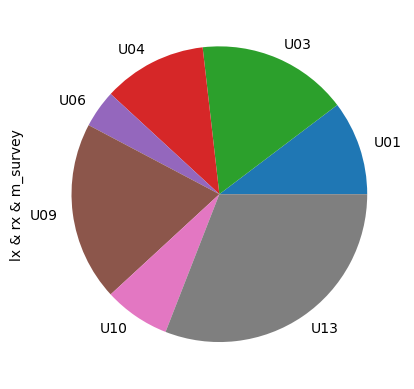

In [15]:
dataset_exloration.T['lx & rx & m_survey'].plot(kind='pie')

## Segmentation

In [14]:
def remove_usr_from_idx(df: DataFrame, key: str) -> DataFrame:
    df = df.loc[IndexSlice[key, :], :]
    df.index = df.index.droplevel(0)
    return df
    
experiment_info_as_dict = {participant: remove_usr_from_idx(df=experiment_info, key=participant)
                           for participant in list(experiment_info.index.get_level_values(0).unique())}

In [15]:
segment_size_in_mins = 10
segment_size_in_secs = segment_size_in_mins * 60
eda_sample_rate = 4
segment_size_in_sampling_rate: int = segment_size_in_secs * eda_sample_rate

In [16]:
eda_data = physiological_data['EDA']

In [17]:
# user = "U13"
# info = experiment_info_as_dict[user]
# data = eda_data['left'][user]

In [23]:
from numpy import nan, ndarray
from pandas import Timedelta


def get_session_moment(start: Timestamp, end: Timestamp, info: Series) -> int | float:
    # this method gives 0 if the person is awake and 1 if the person is
    if (start < info["actual_bed_time"] and end < info["actual_bed_time"]) or (
        start > info["wake_up_time"] and end > info["wake_up_time"]
    ):
        return 0
    elif (start < info["actual_bed_time"] and end > info["actual_bed_time"]) or (
        start < info["wake_up_time"] and end > info["wake_up_time"]
    ):
        return nan
    else:
        return 1


data_segmented_left: list[tuple] = []
data_segmented_right: list[tuple] = []
users = list(set(eda_data["left"].keys()) & set(eda_data["right"].keys()))

for user in users:
    data_left = eda_data["left"][user]
    data_right = eda_data["right"][user]
    info = experiment_info_as_dict[user]
    sessions = list(
        set(data_left.index.get_level_values(0).unique())
        & set(data_right.index.get_level_values(0).unique())
    )
    morning_survey_sessions = (
        experiment_info.loc[IndexSlice[user, :], :].index.get_level_values(1).unique()
    )

    sessions_all = list(set(sessions) & set(morning_survey_sessions))

    for session in tqdm(sessions_all, desc=f"Splitting {user=}. Sessions progress:"):
        session_data_left: DataFrame = data_left.loc[IndexSlice[session, :], :]
        session_data_right: DataFrame = data_right.loc[IndexSlice[session, :], :]

        session_info = info.loc[session, :]

        starts_left = session_data_left[
            ::segment_size_in_sampling_rate
        ].index.get_level_values(1)
        starts_right = session_data_right[
            ::segment_size_in_sampling_rate
        ].index.get_level_values(1)

        ends_left = (
            session_data_left[::segment_size_in_sampling_rate].index.get_level_values(1)
            + Timedelta(f"{segment_size_in_mins}min")
            - Timedelta(f"{1/eda_sample_rate}s")
        )
        ends_right = (
            session_data_right[::segment_size_in_sampling_rate].index.get_level_values(
                1
            )
            + Timedelta(f"{segment_size_in_mins}min")
            - Timedelta(f"{1/eda_sample_rate}s")
        )

        segments_left = [
            (
                session_data_left.loc[
                    IndexSlice[session, start:end],
                    "mixed-EDA",
                ].values,
                get_session_moment(start, end, session_info),
            )
            for start, end in zip(starts_left, ends_left)
        ]
        segments_right = [
            (
                session_data_right.loc[
                    IndexSlice[session, start:end],
                    "mixed-EDA",
                ].values,
                get_session_moment(start, end, session_info),
            )
            for start, end in zip(starts_right, ends_right)
        ]
        data_segmented_left.append(segments_left)
        data_segmented_right.append(segments_right)


Splitting user='U01'. Sessions progress::   0%|          | 0/10 [00:00<?, ?it/s]

Splitting user='U10'. Sessions progress::   0%|          | 0/7 [00:00<?, ?it/s]

Splitting user='U02'. Sessions progress:: 0it [00:00, ?it/s]

Splitting user='U13'. Sessions progress::   0%|          | 0/30 [00:00<?, ?it/s]

Splitting user='U04'. Sessions progress::   0%|          | 0/11 [00:00<?, ?it/s]

Splitting user='U06'. Sessions progress::   0%|          | 0/4 [00:00<?, ?it/s]

Splitting user='U09'. Sessions progress::   0%|          | 0/19 [00:00<?, ?it/s]

Splitting user='U03'. Sessions progress::   0%|          | 0/16 [00:00<?, ?it/s]

In [52]:
from numpy import isnan
values_left = [
    val[0]
    for segments in data_segmented_left
    for val in segments
    if not isnan(val[1])
]
values_right = [
    val[0]
    for segments in data_segmented_right
    for val in segments
    if not isnan(val[1])
]

labels_left = [
    val[1]
    for segments in data_segmented_left
    for val in segments
    if not isnan(val[1])
]
labels_right = [
    val[1]
    for segments in data_segmented_right
    for val in segments
    if not isnan(val[1])
]


1    3989
0     838
dtype: int64
1    82.63932
0    17.36068
dtype: float64


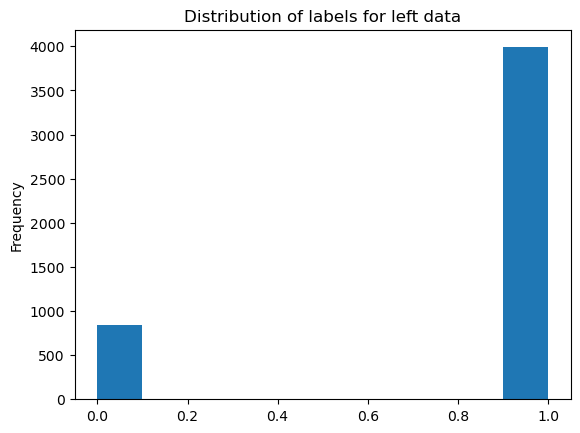

In [53]:
import matplotlib.pyplot as plt

Series(labels_left).plot(kind="hist")
plt.title('Distribution of labels for left data')
print(Series(labels_left).value_counts())
print(Series(labels_left).value_counts()/Series(labels_left).count()*100)

1    4059
0     845
dtype: int64
1    82.769168
0    17.230832
dtype: float64


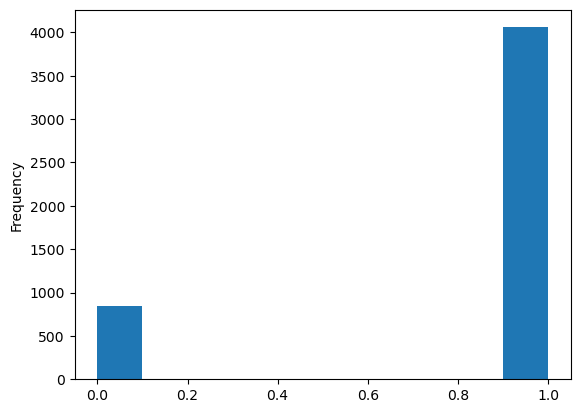

In [54]:
Series(labels_right).plot(kind="hist")
print(Series(labels_right).value_counts())
print(Series(labels_right).value_counts()/Series(labels_right).count()*100)

Approximately 82% of the labels are from the positive class (asleep). This means that undersampling will be extremely necessary.

## Feature Extraction

In [55]:
from sys import path
path.append("../")
from joblib import Parallel, delayed
from src.feature_extraction.eda import get_eda_features

features_left = Parallel(n_jobs=-1)(delayed(get_eda_features)(value) for value in (values_left))
features_right = Parallel(n_jobs=-1)(delayed(get_eda_features)(value) for value in (values_right))

Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
/Users/leonardoalchieri/miniconda3/envs/laugh/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
/Users/leonardoalchieri/miniconda3/envs/laugh/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could 

In [56]:
from numpy import stack

features_left = stack(features_left)
features_right = stack(features_right)

In [57]:
labels_left = stack(labels_left)
labels_right = stack(labels_right)

# ML Prediction

### LX v LX

In [110]:
from sklearn.model_selection import KFold
from imblearn.under_sampling import RandomUnderSampler
from lazypredict.Supervised import LazyClassifier
import pandas as pd

x, y = features_left, labels_left
cc = RandomUnderSampler(random_state=42)
x_resampled, y_resampled = cc.fit_resample(x, y)

folds = KFold(n_splits=5, random_state=42, shuffle=True).split(x_resampled, y_resampled)
all_models = []
for train_index, test_index in tqdm(folds, desc="Folds progress:", total=5):
    x_train, x_test = x_resampled[train_index], x_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]
    clf = LazyClassifier(predictions=True)
    models, predictions = clf.fit(x_train, x_test, y_train, y_test)
    all_models.append(models)


averages = (
    pd.concat(all_models)
    .groupby(level=0)
    .mean()
    .sort_values(by="Accuracy", ascending=False)
)
standard_deviations = (
    pd.concat(all_models)
    .groupby(level=0)
    .std()
    .sort_values(by="Accuracy", ascending=False)
)
standard_errors = standard_deviations / 5**0.5


Folds progress::   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:02<00:00, 11.19it/s]


In [111]:
pd.concat([averages, standard_errors], axis=1, keys=["Average", "Standard error"])

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
RandomForestClassifier            0.80              0.79    0.79     0.80   
XGBClassifier                     0.79              0.79    0.79     0.79   
LGBMClassifier                    0.79              0.79    0.79     0.79   
ExtraTreesClassifier              0.78              0.78    0.78     0.78   
CalibratedClassifierCV            0.78              0.78    0.78     0.78   
NuSVC                             0.78              0.78    0.78     0.78   
AdaBoostClassifier                0.78              0.78    0.78     0.78   
LinearSVC                         0.78              0.78    0.78     0.77   
SVC                               0.78              0.78    0.78     0.78   
LogisticRegression                0.78              0.78    0.78     0.78   
RidgeClassifier                   0.77              0.77    0.77     0.77   
LinearDiscriminantAnalysis        0.77              0.77    0.77     0.77   
RidgeClassifierCV                 0.77              0.77    0.77     0.77   
KNeighborsClassifier              0.77              0.77    0.77     0.77   
BaggingClassifier                 0.77              0.77    0.77     0.77   
LabelSpreading                    0.76              0.76    0.76     0.76   
LabelPropagation                  0.76              0.76    0.76     0.76   
SGDClassifier                     0.75              0.75    0.75     0.75   
DecisionTreeClassifier            0.73              0.73    0.73     0.73   
BernoulliNB                       0.73              0.73    0.73     0.73   
NearestCentroid                   0.72              0.72    0.72     0.71   
ExtraTreeClassifier               0.72              0.72    0.72     0.72   
Perceptron                        0.71              0.71    0.71     0.71   
QuadraticDiscriminantAnalysis     0.70              0.70    0.70     0.69   
PassiveAggressiveClassifier       0.70              0.70    0.70     0.69   
GaussianNB                        0.68              0.68    0.68     0.66   
DummyClassifier                   0.48              0.50    0.50     0.31   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
RandomForestClassifier              0.23           0.01              0.01   
XGBClassifier                       0.56           0.01              0.01   
LGBMClassifier                      1.06           0.01              0.01   
ExtraTreesClassifier                0.10           0.01              0.01   
CalibratedClassifierCV              0.22           0.02              0.02   
NuSVC                               0.05           0.01              0.01   
AdaBoostClassifier                  0.08           0.01              0.01   
LinearSVC                           0.06           0.01              0.01   
SVC                                 0.07           0.01              0.01   
LogisticRegression                  0.01           0.02              0.02   
RidgeClassifier                     0.01           0.01              0.01   
LinearDiscriminantAnalysis          0.01           0.01              0.01   
RidgeClassifierCV                   0.01           0.01              0.01   
KNeighborsClassifier                0.01           0.01              0.00   
BaggingClassifier                   0.05           0.01              0.01   
LabelSpreading                      0.04           0.01              0.01   
LabelPropagation                    0.03           0.01              0.01   
SGDClassifier                       0.01           0.03              0.03   
DecisionTreeClassifier              0.01           0.01              0.01   
BernoulliNB               

### RX vs RX

In [112]:
from sklearn.model_selection import KFold
from imblearn.under_sampling import RandomUnderSampler
from lazypredict.Supervised import LazyClassifier
import pandas as pd

x, y = features_right, labels_right
cc = RandomUnderSampler(random_state=42)
x_resampled, y_resampled = cc.fit_resample(x, y)

folds = KFold(n_splits=5, random_state=42, shuffle=True).split(x_resampled, y_resampled)
all_models = []
for train_index, test_index in tqdm(folds, desc="Folds progress:", total=5):
    x_train, x_test = x_resampled[train_index], x_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]
    clf = LazyClassifier(predictions=True)
    models, predictions = clf.fit(x_train, x_test, y_train, y_test)
    all_models.append(models)
    


averages = pd.concat(all_models).groupby(level=0).mean().sort_values(by="Accuracy", ascending=False)
standard_deviations = pd.concat(all_models).groupby(level=0).std().sort_values(by="Accuracy", ascending=False)
standard_errors = standard_deviations/5**0.5

Folds progress::   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:02<00:00,  9.83it/s]


In [113]:
pd.concat([averages, standard_errors], axis=1, keys=["Average", "Standard error"])

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
XGBClassifier                     0.76              0.76    0.76     0.76   
LGBMClassifier                    0.76              0.76    0.76     0.76   
ExtraTreesClassifier              0.75              0.75    0.75     0.75   
RandomForestClassifier            0.75              0.75    0.75     0.75   
NuSVC                             0.75              0.75    0.75     0.75   
AdaBoostClassifier                0.75              0.75    0.75     0.75   
KNeighborsClassifier              0.74              0.74    0.74     0.74   
CalibratedClassifierCV            0.74              0.74    0.74     0.73   
SVC                               0.74              0.73    0.73     0.73   
BaggingClassifier                 0.74              0.74    0.74     0.73   
LogisticRegression                0.73              0.73    0.73     0.73   
LinearSVC                         0.73              0.73    0.73     0.73   
RidgeClassifierCV                 0.73              0.73    0.73     0.72   
SGDClassifier                     0.72              0.72    0.72     0.72   
LinearDiscriminantAnalysis        0.72              0.73    0.73     0.72   
RidgeClassifier                   0.72              0.73    0.73     0.72   
LabelSpreading                    0.71              0.72    0.72     0.71   
LabelPropagation                  0.71              0.72    0.72     0.71   
Perceptron                        0.70              0.70    0.70     0.70   
QuadraticDiscriminantAnalysis     0.68              0.68    0.68     0.67   
DecisionTreeClassifier            0.67              0.67    0.67     0.67   
BernoulliNB                       0.67              0.67    0.67     0.66   
NearestCentroid                   0.66              0.66    0.66     0.64   
GaussianNB                        0.66              0.66    0.66     0.63   
ExtraTreeClassifier               0.65              0.65    0.65     0.65   
PassiveAggressiveClassifier       0.57              0.58    0.58     0.53   
DummyClassifier                   0.48              0.50    0.50     0.31   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
XGBClassifier                       0.59           0.01              0.01   
LGBMClassifier                      1.04           0.01              0.01   
ExtraTreesClassifier                0.10           0.02              0.02   
RandomForestClassifier              0.22           0.01              0.01   
NuSVC                               0.06           0.01              0.01   
AdaBoostClassifier                  0.09           0.02              0.02   
KNeighborsClassifier                0.01           0.01              0.01   
CalibratedClassifierCV              0.22           0.02              0.02   
SVC                                 0.06           0.02              0.02   
BaggingClassifier                   0.06           0.02              0.01   
LogisticRegression                  0.02           0.02              0.02   
LinearSVC                           0.08           0.02              0.02   
RidgeClassifierCV                   0.00           0.02              0.02   
SGDClassifier                       0.01           0.02              0.02   
LinearDiscriminantAnalysis          0.01           0.02              0.02   
RidgeClassifier                     0.01           0.02              0.02   
LabelSpreading                      0.04           0.01              0.01   
LabelPropagation                    0.03           0.01              0.01   
Perceptron                          0.00           0.02              0.02   
QuadraticDiscriminantAnaly

### LX vs RX

In [114]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(predictions=True)
x_resampled_lx, y_resampled_lx = cc.fit_resample(features_left, labels_left)
x_resampled_rx, y_resampled_rx = cc.fit_resample(features_right, labels_right)
models, predictions = clf.fit(x_resampled_lx, x_resampled_rx, y_resampled_lx, y_resampled_rx)

100%|██████████| 29/29 [00:03<00:00,  8.39it/s]


In [115]:
models.sort_values(by="Balanced Accuracy", ascending=False)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LogisticRegression,0.75,0.75,0.75,0.75,0.02
NuSVC,0.75,0.75,0.75,0.74,0.21
SVC,0.74,0.74,0.74,0.74,0.17
LinearSVC,0.74,0.74,0.74,0.74,0.09
CalibratedClassifierCV,0.74,0.74,0.74,0.74,0.28
RidgeClassifierCV,0.73,0.73,0.73,0.73,0.03
LinearDiscriminantAnalysis,0.73,0.73,0.73,0.73,0.01
RidgeClassifier,0.73,0.73,0.73,0.73,0.03
LGBMClassifier,0.72,0.72,0.72,0.72,0.92


### RX vs LX

In [116]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(predictions=True)
x_resampled_lx, y_resampled_lx = cc.fit_resample(features_left, labels_left)
x_resampled_rx, y_resampled_rx = cc.fit_resample(features_right, labels_right)
models, predictions = clf.fit(x_resampled_rx, x_resampled_lx, y_resampled_rx, y_resampled_lx)

100%|██████████| 29/29 [00:03<00:00,  8.58it/s]


In [117]:
models.sort_values(by="Balanced Accuracy", ascending=False)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.78,0.78,0.78,0.78,0.32
XGBClassifier,0.77,0.77,0.77,0.77,0.52
LGBMClassifier,0.77,0.77,0.77,0.77,0.96
NuSVC,0.77,0.77,0.77,0.77,0.21
ExtraTreesClassifier,0.76,0.76,0.76,0.76,0.17
BaggingClassifier,0.76,0.76,0.76,0.76,0.07
LogisticRegression,0.76,0.76,0.76,0.75,0.02
CalibratedClassifierCV,0.75,0.75,0.75,0.75,0.29
LinearSVC,0.75,0.75,0.75,0.74,0.10


# USILaughs

## Cognitive Load Info

In [15]:
from pandas import read_csv, to_datetime
from pandas import IndexSlice, DataFrame

In [16]:
def move_event_to_columns(df):
    starts = {}
    ends = {}
    for event in df.index.get_level_values(1).unique():
        starts[f"start_{event}"] = df.loc[IndexSlice[:, event], "start"].values
        ends[f"end_{event}"] = df.loc[IndexSlice[:, event], "end"].values
    return DataFrame({**starts, **ends})


experiment_info = read_csv(
    "../data.nosync/usilaughs/all_experimento_info.csv", index_col=[0, 1]
)
indexes_to_drop = [
    idx
    for idx in experiment_info.index
    if "baseline" not in idx[1] and "cognitive_load" not in idx[1]
]
experiment_info = experiment_info.drop(indexes_to_drop, inplace=False)
experiment_info = experiment_info.groupby(axis=0, level=0, group_keys=True).apply(
    move_event_to_columns
)
experiment_info.index = experiment_info.index.droplevel(1)


In [17]:
experiment_info = experiment_info.applymap(to_datetime)
experiment_info = experiment_info.applymap(lambda x: x.tz_localize('Europe/Rome'))

## Physiological Data

In [18]:
from pandas import read_csv, read_parquet
from glob import glob
from collections import defaultdict
from pandas import Series
from tqdm.auto import tqdm
from plotly.subplots import make_subplots
from plotly.graph_objects import Figure, Scatter
from random import choice as choose_randomly
from pandas import Timestamp
from pandas.core.indexes.base import Index
from tqdm.notebook import tqdm
from pandas import DataFrame, IndexSlice
from gc import collect as garbage_collect

eda_data_base_path: str = "../data.nosync/usilaughs/filtered/*/EDA/*.parquet"
eda_data_paths: list[str] = glob(eda_data_base_path)
eda_data: defaultdict[str, defaultdict[str, Series]] = defaultdict(
    lambda: defaultdict()
)
for file in tqdm(eda_data_paths, desc="Loading EDA data"):
    side_name = file.split("/")[-3]
    user_name = file.split("/")[-1].split(".")[0]
    eda_data[side_name][user_name] = read_parquet(file)

bvp_data = None

# bvp_data_base_path: str = "../data/filtered/*/BVP/*.parquet"
# bvp_data_paths: list[str] = glob(bvp_data_base_path)
# bvp_data: defaultdict[str, defaultdict[str, Series]] = defaultdict(
#     lambda: defaultdict()
# )
# for file in tqdm(bvp_data_paths, desc="Loading BVP data"):
#     side_name = file.split("/")[-3]
#     user_name = file.split("/")[-1].split(".")[0]
#     bvp_data[side_name][user_name] = read_parquet(file)
    
    
physiological_data: dict[str, defaultdict[str, defaultdict[str, Series]]] = {
    "EDA": eda_data,
    "BVP": bvp_data,
}
del eda_data
del bvp_data
garbage_collect()

Loading EDA data:   0%|          | 0/67 [00:00<?, ?it/s]

174

After inspection, user 40 has to be removed, since his experiment time and the timestamps from the E4 do not match.

In [19]:
experiment_info = experiment_info.drop('s040', axis=0, inplace=False)
del physiological_data['EDA']['left']['s040']
del physiological_data['EDA']['right']['s040']
# del physiological_data['BVP']['left']['s040']
# del physiological_data['BVP']['right']['s040']

In [22]:
users_left = physiological_data["EDA"]["left"].keys()
users_right = physiological_data["EDA"]["right"].keys()
users = list(set(users_left) & set(users_right))
sessions_all = ['experiment']

In [25]:
# session = session_selection.value
for user in tqdm(sorted(users), desc='Plotting user data', colour='red'):
    for session in sessions_all:
        make_biometrics_plots_together_matplotlib(
            data=physiological_data,
            user_id=user,
            session_id=session,
            dataset='usi_laughs',
            experiment_info=experiment_info,
            eda_type="mixed-EDA",
        )


Plotting user data:   0%|          | 0/32 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

In [26]:
users_in_left_side = set(physiological_data['EDA']['left'].keys())
users_in_right_side = set(physiological_data['EDA']['right'].keys())

In [27]:
print(f"Number of users with both left and right hand data: {len(users_in_left_side & users_in_right_side)}")

Number of users with both left and right hand data: 32
